# Notebook for analysing all Stripe tracking / VR trials in one experiment folder

## (assumes use of FlyOver version 9.5 or higher)

In [142]:
import numpy as np
import pandas as pd
    
from os import mkdir, walk, getcwd
from os.path import isfile, sep
from sys import path, exit
from glob import glob
from scipy.interpolate import interp1d
from scipy import stats as sts
from scipy.optimize import curve_fit
from scipy.stats import circmean as circmean

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import rcParams
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

# import basic data processing function
from flyVR.utilities.loadSingleTrial import loadSingleVRLogfile
from flyVR.utilities.loadObjectCoords import loadObjectCoordIdentities

from flyVR.flyVRstripetracking.flyVRstripetracking_fourConditions_oneFlyAnalysis import processTrackingTrial

from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec, RayleighTest

# import custom plotting functions
from plottingUtilities.basicPlotting import myAxisTheme, _myAccentList
from plottingUtilities.objectInteractionPlots import plotHeadingComparison, plot2DHeadingComparison,plotWalkingVelocityDistr

import seaborn as sns
sns.set_style('ticks')

%matplotlib inline 

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [143]:
# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/'

root = Tk()
# prevents root window from appearing
root.withdraw()
root.update()

# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


### Compose mutli-fly data into dataframe

In [144]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [145]:
keylist = ['gamma','gammaFull','headingAngle','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','LMdist','moving']

keylistLong = ['flyID','trial','trialtype','sceneName'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [146]:
genotype = dataDir.split('/')[-5]
genotype

'DL-highT'

In [147]:
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = currExpDir
        trial = FODataFiles.index(fileToAnalyse) + 1
        sceneName = fileToAnalyse.split('_')[1]
        
        if rerunbasicanalysis == 'y':
            #Load and process raw data
            titleString = 'fly '+flyID+' ('+genotype+')'+' in '+sceneName+' world'
            processTrackingTrial(expDir, fileToAnalyse, '/'.join(dataDir.split('/')[:-2])+'/', titleString)
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
            print('Ran analysis, now loading saved *.npy file.')
        else:
            # just load existing npy file with processed data
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
    
        if ('Stripe' in fileToAnalyse or 'stripe' in fileToAnalyse):
            trialtype = 'stripe'
        else:
            trialtype = 'plane'

        if ('inverted' in fileToAnalyse or 'Inverted' in fileToAnalyse):
            sceneName = 'inverted'+sceneName

        # add to data frame
        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'sceneName', sceneName)
        FODatLoad_df.insert(4, 'LMdist', np.hypot(FODatLoad_df['xPosInMiniarena'],FODatLoad_df['yPosInMiniarena']))
    
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/DL-highT/fourConditions/male/rawData/m01/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_DL_m01_5d_out_170324163115.txt', 'singleObjectForest_1cm4cmCone_12cmHex_inverted_DL_m01_5d_out_170324161835.txt', 'stripe20deg_BlackOnWhite_DL_m01_5d_out_170324165508.txt', 'stripe20deg_WhiteOnBlack_DL_m01_5d_out_170324164248.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/DL-highT/fourConditions/male/rawData/m02/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_DL_m02_7d_out_170327111303.txt', 'singleObjectForest_1cm4cmCone_12cmHex_inverted_DL_m02_7d_out_170327112446.txt', 'stripe20deg_BlackOnWhite_DL

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/DL-highT/fourConditions/male/rawData/m15/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_DL_m15_9d_out_170331165944.txt', 'singleObjectForest_1cm4cmCone_12cmHex_inverted_DL_m15_9d_out_170331162507.txt', 'stripe20deg_BlackOnWhite_DL_m15_9d_out_170331163618.txt', 'stripe20deg_WhiteOnBlack_DL_m15_9d_out_170331164741.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.


In [148]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df.head()

flyID trial trialtype   sceneName  gamma  gammaFull  headingAngle   rotVelo  \
0   m01   1.0     plane  1cm4cmCone    NaN        NaN     -0.000004 -0.316760   
1   m01   1.0     plane  1cm4cmCone    NaN        NaN     -0.015844 -0.316150   
2   m01   1.0     plane  1cm4cmCone    NaN        NaN     -0.031653 -0.158247   
3   m01   1.0     plane  1cm4cmCone    NaN        NaN     -0.039567  0.000000   
4   m01   1.0     plane  1cm4cmCone    NaN        NaN     -0.039567  0.316493   

       time  transVelo     xPos  xPosInMiniarena     yPos  yPosInMiniarena  \
0  0.000000   0.755736  60.6220              NaN  35.0000              NaN   
1  0.050006   0.000000  60.5942              NaN  34.9744              NaN   
2  0.100013   0.000000  60.5942              NaN  34.9744              NaN   
3  0.150019   0.000000  60.5942              NaN  34.9744              NaN   
4  0.200025   5.379304  60.5942              NaN  34.9744              NaN   

   LMdist  moving  
0     NaN     0.0  
1     NaN     0.0  
2     NaN     0.0  
3     NaN     0.0  
4     NaN     1.0

In [149]:
flyIDallarray = np.asarray(FOAllFlies_df['flyID']).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))
genotypeSex = genotype+fileToAnalyse.split('_')[-4][0] #-3
genotypeSex

'DL-highTm'

### Parameter settings and definition of experimental conditions

In [150]:
minLMdist = 6 # exclude area directly around LM

angleLow = -np.pi
angleHigh = np.pi

#Selection criteria:
kappaTH = 0.5

In [151]:
sceneNames = list(set(FOAllFlies_df['sceneName'].values.tolist()))

trialCol = ['black','grey','darkblue','steelblue']

sceneNames

['1cm4cmCone', 'inverted1cm4cmCone', 'BlackOnWhite', 'WhiteOnBlack']

### Walking velocity distributions

In [152]:
histRangeVT = (vTransTH, 30)
histRangeVR = (-5,5)
numBins = 25

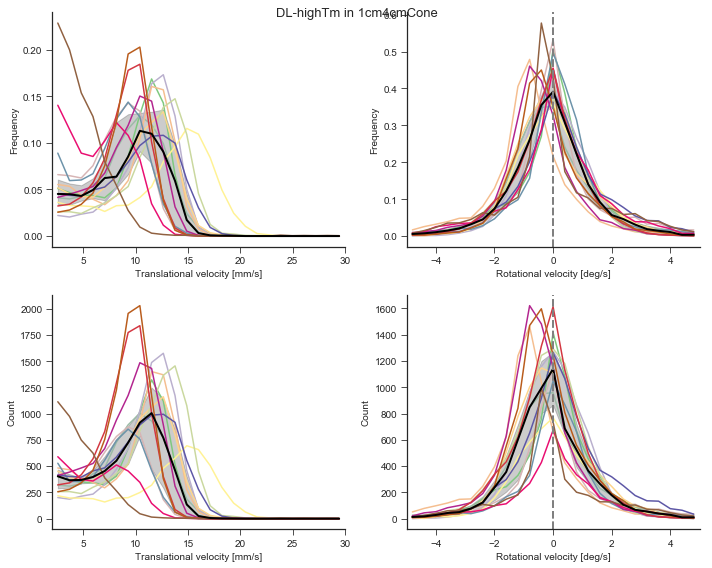

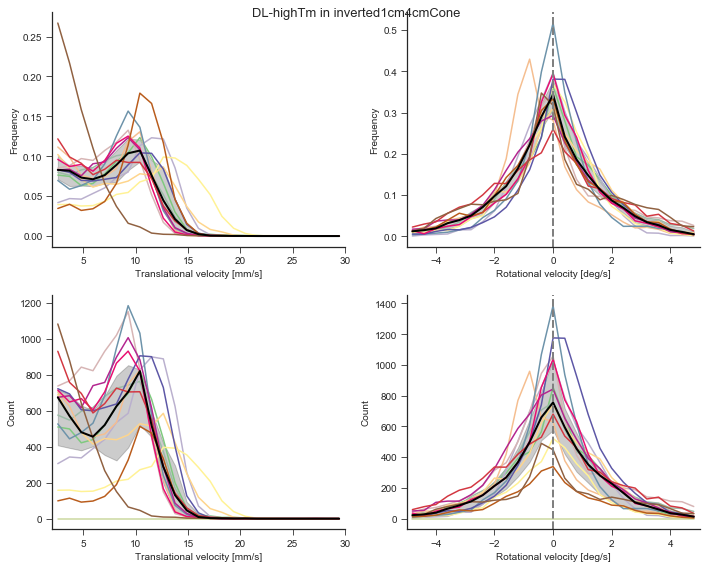

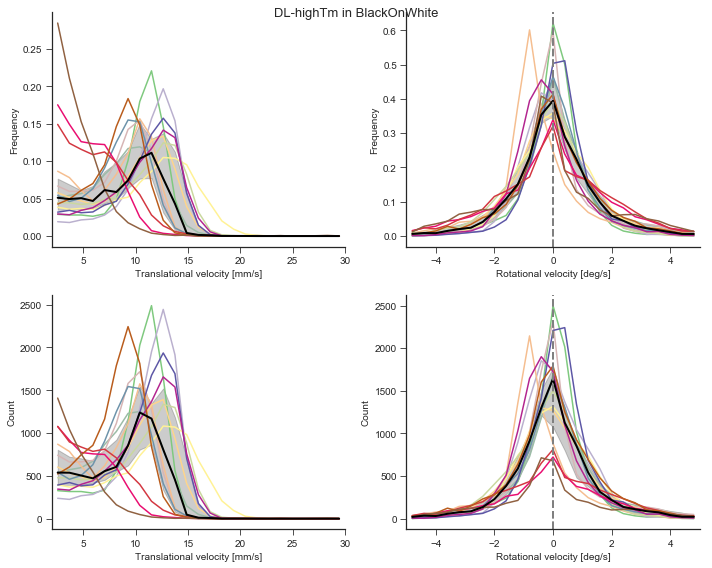

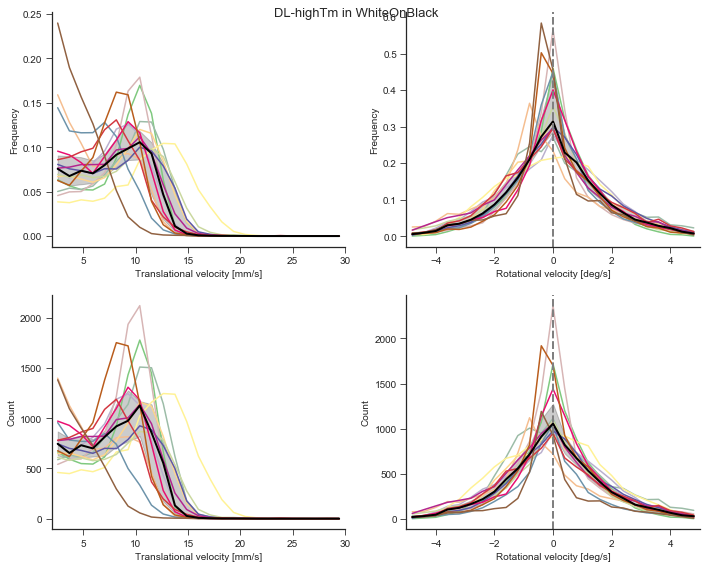

In [153]:
for scene, scenename in enumerate(sceneNames):
    scene_df = FOAllFlies_df.query('sceneName == "' + scenename+'"')
    if scene_df['trialtype'].values[0] == 'plane':
        scene_df = scene_df.query('LMdist > '+str(minLMdist))
    
    titleString = genotypeSex+' in '+ scenename
    
    walkingFig = plotWalkingVelocityDistr(scene_df, flyIDs, flyCMap, histRangeVT, histRangeVR, numBins)
    walkingFig.suptitle(titleString, fontsize=13)
    walkingFig.tight_layout()

    walkingFig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotypeSex + '_walkingVelocities_'+scenename+\
                       '_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

### Heading angle distribution (if stripe)

In [154]:
try:
    mkdir(analysisDir + sep + 'heading' + sep)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


1cm4cmCone
inverted1cm4cmCone
BlackOnWhite
WhiteOnBlack


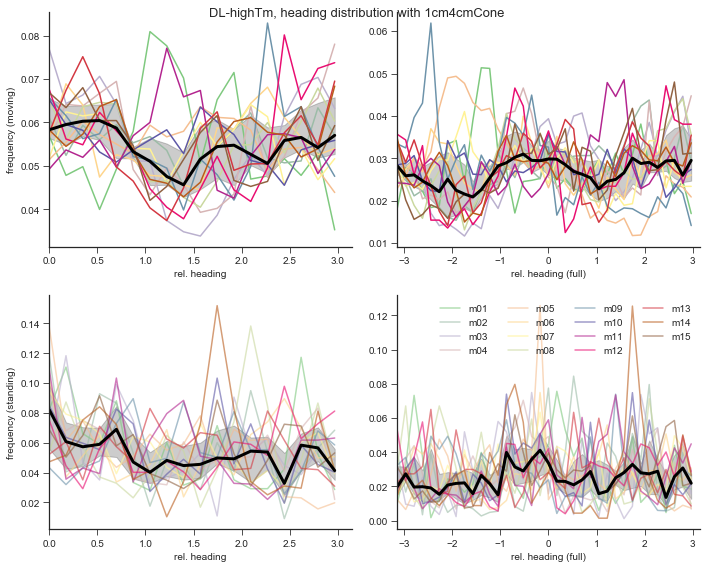

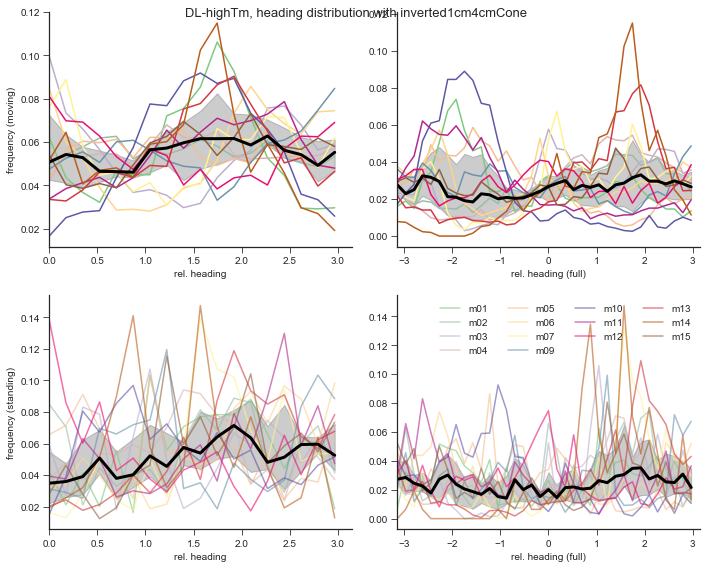

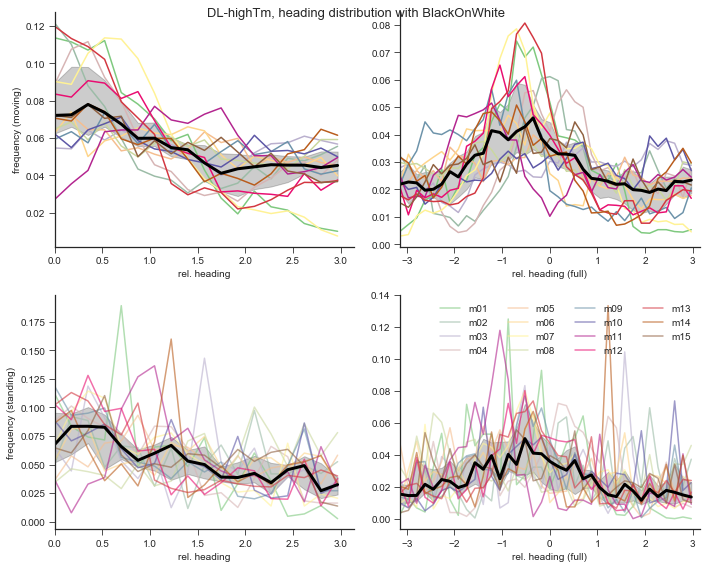

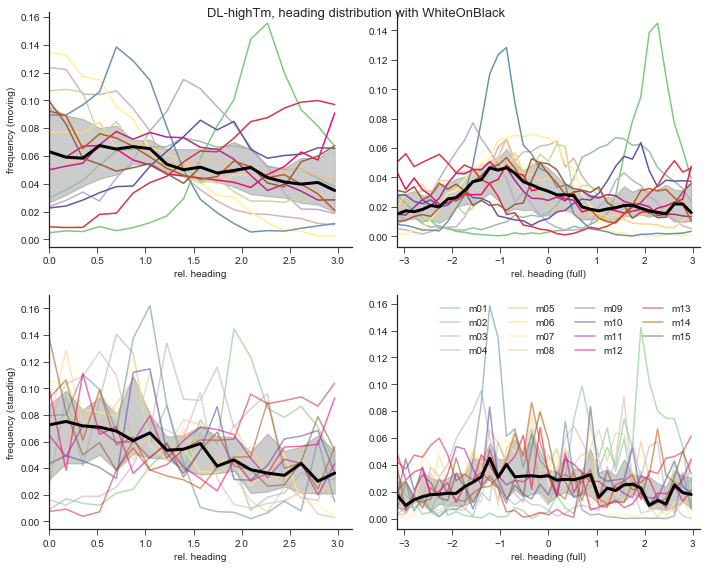

In [155]:
for scene in range(len(sceneNames)):

    scenename = sceneNames[scene]
    print(scenename)
    densityFlag = True
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig, nhead_fullGamma = plotHeadingComparison(FOAllFlies_df, flyIDs, scenename,minLMdist,
                                                        titleString, flyCMap, densityFlag, True)
    
    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

1cm4cmCone
inverted1cm4cmCone
BlackOnWhite
WhiteOnBlack


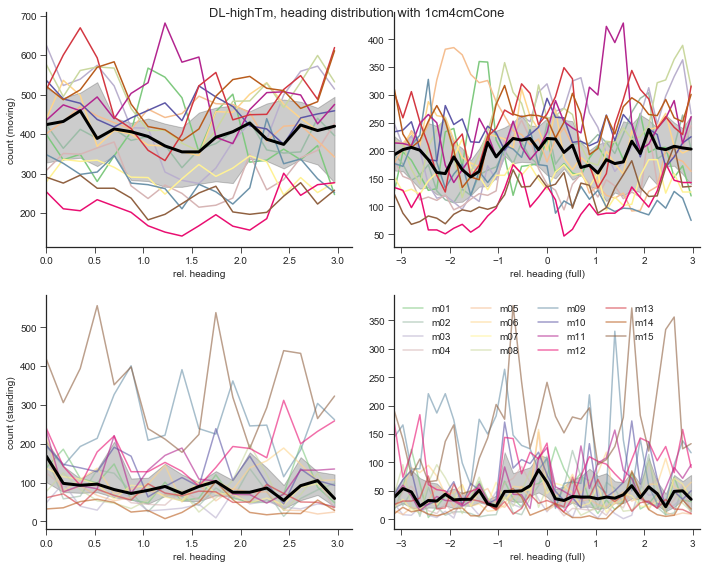

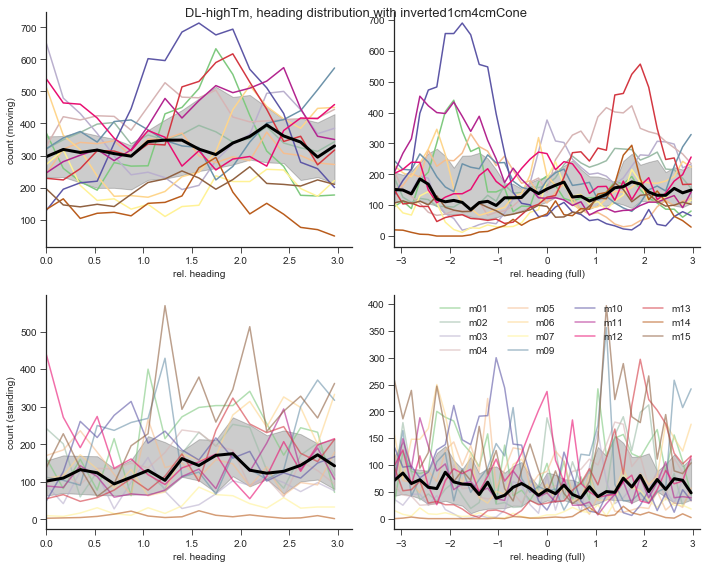

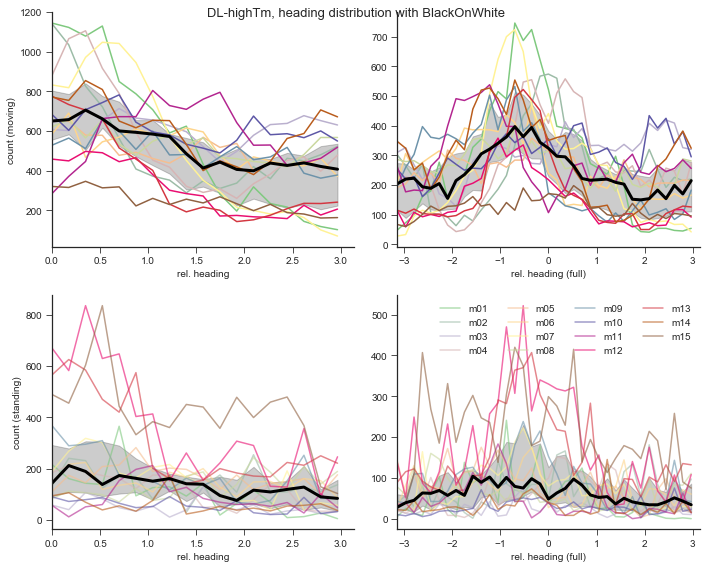

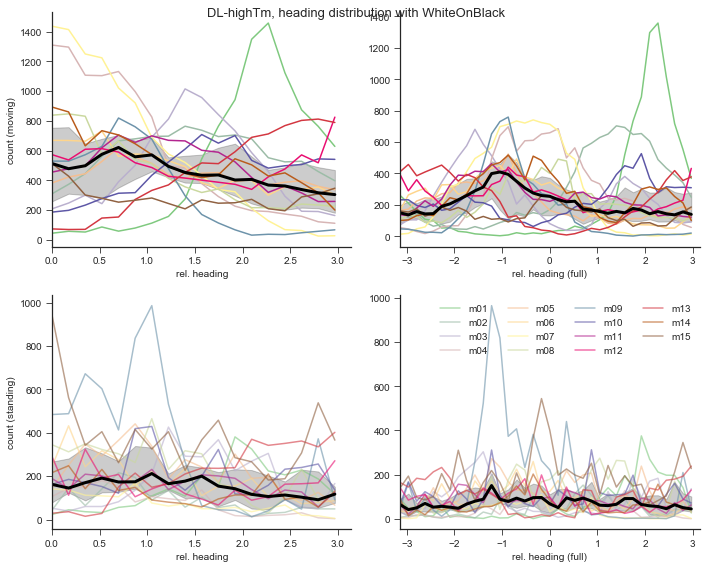

In [156]:
for scene in range(len(sceneNames)):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    print(scenename)
    
    densityFlag = False
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig, nhead_fullGamma = plotHeadingComparison(FOAllFlies_df, flyIDs, scenename,minLMdist,
                                                        titleString, flyCMap, densityFlag, True)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

### Comparison between relative heading and absolute heading in 2D worlds (they are the same in 1D)

1cm4cmCone

inverted1cm4cmCone



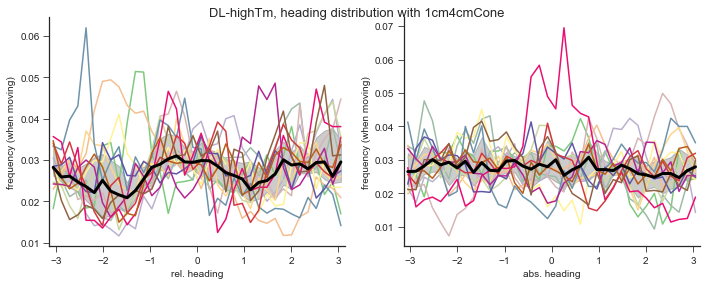

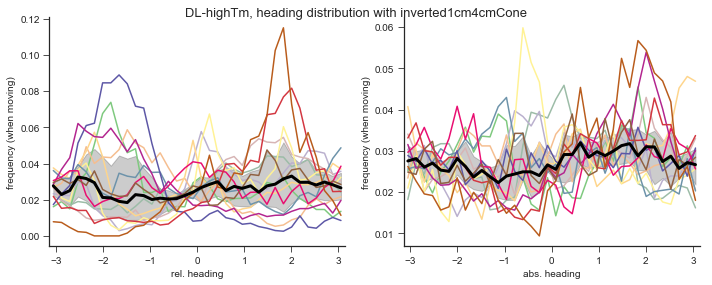

In [157]:
for scene in [0,1]:
    scenename = sceneNames[scene]
    print(scenename+'\n')
    densityFlag = True
    
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plot2DHeadingComparison(FOAllFlies_df, flyIDs, scenename,minLMdist, titleString, flyCMap, densityFlag, True)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_rel-abs-heading_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

## Circular statistics on heading distribution

In [158]:
headingPVA = np.nan*np.ones((len(sceneNames),numFlies,2))
anglePVA = np.nan*np.ones((len(sceneNames),numFlies,2))
fliesNotWalking = np.zeros((len(sceneNames)))

for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]
    print('\n'+scenename+'\n')
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + scenename + '") & (flyID =="' + flyIDs[fly] +  '")'
        scene_df = FOAllFlies_df.query(querystring)
        if len(scene_df) == 0: continue
        nTrial = len(scene_df['moving'].squeeze().astype('int').values)
        if scene_df['trialtype'].values[0] == 'plane':
            scene_df = scene_df.query('LMdist > '+str(minLMdist))
        
        moving = scene_df['moving'].squeeze().astype('int').values
        perFlyG = scene_df['gammaFull'].squeeze().astype('float').values
        perFlyA = scene_df['headingAngle'].squeeze().astype('float').values

        if sum(moving)<=0.2*nTrial:
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,nTrial)))
            fliesNotWalking[scene] += 1
            continue
            
        gamFul = perFlyG[moving>0]
        meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

        headingPVA[scene,fly,0] = meandir
        headingPVA[scene,fly,1] = meanlen
        
        angle = perFlyA[moving>0]
        meandir, meanlen = circmeanvec(angle[~np.isnan(angle)],np.ones(len(angle[~np.isnan(angle)])), high=angleHigh, low=angleLow)

        anglePVA[scene,fly,0] = meandir
        anglePVA[scene,fly,1] = meanlen
        
try:
    mkdir(analysisDir + sep + 'circStats' + sep)
except OSError:
    print('Analysis directory already exists.')
        
np.savetxt(analysisDir + 'circStats/'  + genotype + '_headingPVA_dir_'+scenename+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_headingPVA_len_'+scenename+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,:,1], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_anglePVA_dir_'+scenename+'_n'+ str(numFlies) +'.csv',
           anglePVA[:,:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_anglePVA_len_'+scenename+'_n'+ str(numFlies) +'.csv',
           anglePVA[:,:,1], delimiter=',')


1cm4cmCone


inverted1cm4cmCone


BlackOnWhite


WhiteOnBlack

Analysis directory already exists.


In [159]:
def polarHeadingPlot(titlestr,ax, r, theta, col, dotsize,alphaval):
    ax.plot(r,theta,'.',markersize=dotsize,color=col,alpha=alphaval)
    ax.set_theta_zero_location('N')
    ax.set_xticklabels(['0','', r'$\frac{\pi}{2}$','', r'$\pi,-\pi$','', r'$-\frac{\pi}{2}$',''],fontsize=12)
    ax.set_rlim(0,1)
    ax.set_rlabel_position(225)
    ax.set_title(titlestr)

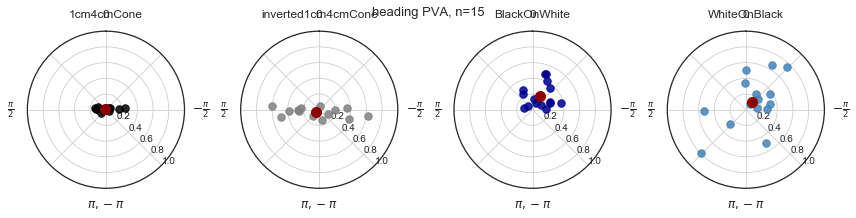

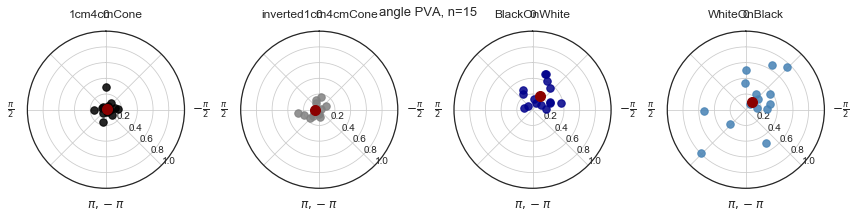

In [160]:
redheadPVAFig = plt.figure(figsize=(12,3))
absheadPVAFig = plt.figure(figsize=(12,3))

for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]    

    ax = redheadPVAFig.add_subplot(1,len(sceneNames),scene+1,projection='polar')
    polarHeadingPlot(scenename,ax, headingPVA[scene,:,0],headingPVA[scene,:,1],trialCol[scene],15,0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,~np.isnan(headingPVA[scene,:,0]),0],\
                                   headingPVA[scene,~np.isnan(headingPVA[scene,:,1]),1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    
    ax = absheadPVAFig.add_subplot(1,len(sceneNames),scene+1,projection='polar')
    polarHeadingPlot(scenename,ax, anglePVA[scene,:,0],anglePVA[scene,:,1],trialCol[scene],15,0.85)
    meandir, meanlen = circmeanvec(anglePVA[scene,~np.isnan(anglePVA[scene,:,0]),0],\
                                   anglePVA[scene,~np.isnan(anglePVA[scene,:,1]),1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)

redheadPVAFig.tight_layout()
redheadPVAFig.suptitle('heading PVA, n='+str(numFlies),fontsize=13)
redheadPVAFig.savefig(analysisDir + 'circStats/'  + genotype
                + '_headingPVA_n'+ str(numFlies) +'.pdf', format='pdf') 

absheadPVAFig.tight_layout()
absheadPVAFig.suptitle('angle PVA, n='+str(numFlies),fontsize=13)
absheadPVAFig.savefig(analysisDir + 'circStats/'  + genotype
                + '_anglePVA_n'+ str(numFlies) +'.pdf', format='pdf') 

## Fit von Mises distribution

In [161]:
def vMFunc(x, mu, kappa):
    return np.exp(kappa * np.cos(x-mu)) / (2*np.pi*np.i0(kappa))

def vMbiModFunc(x, mu1, mu2, kappa):
    return ( (np.exp(kappa * np.cos(x-mu1)) / (2*np.pi*np.i0(kappa))) + (np.exp(kappa * np.cos(x-mu2)) / (2*np.pi*np.i0(kappa))) )/2

In [162]:
def plotOneTrialHeading(ax1, ax2, gammaful, time, meandir, meanlen):
    ax1.plot(time, gammaful)
    ax1.set_ylim(angleLow, angleHigh)
    ax1.set_xlim(0,600)
    myAxisTheme(ax1)
    
    ax2.plot(meandir, meanlen,'.',markersize=15,color='steelblue',alpha=0.85)
    ax2.set_rlim(0,0.8)
    ax2.set_rlabel_position(180)
    ax2.set_title('heading PVA, ' + sceneName + ', n='+str(numFlies))

### Fit unimodal von Mises

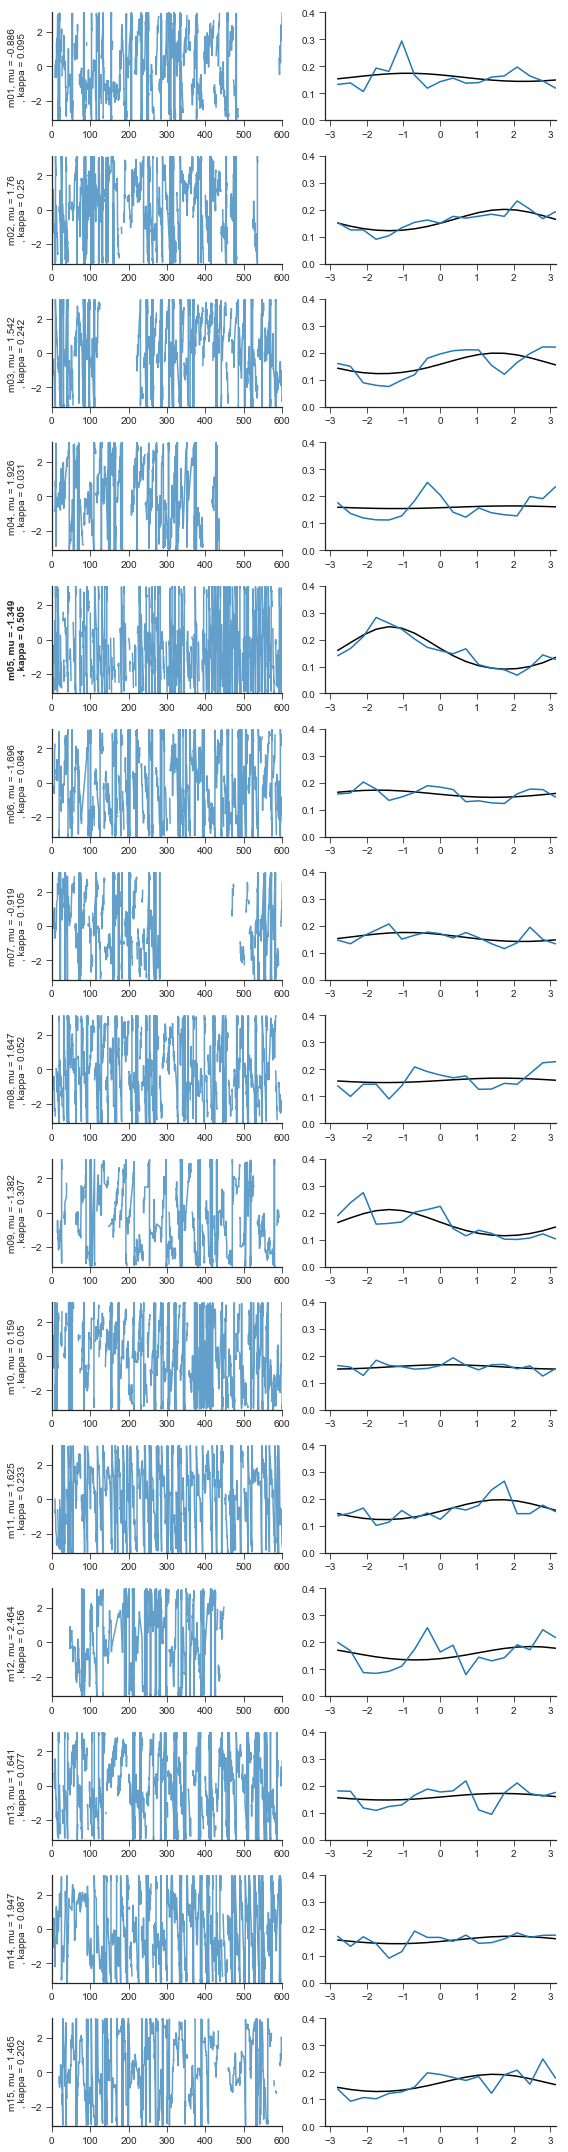

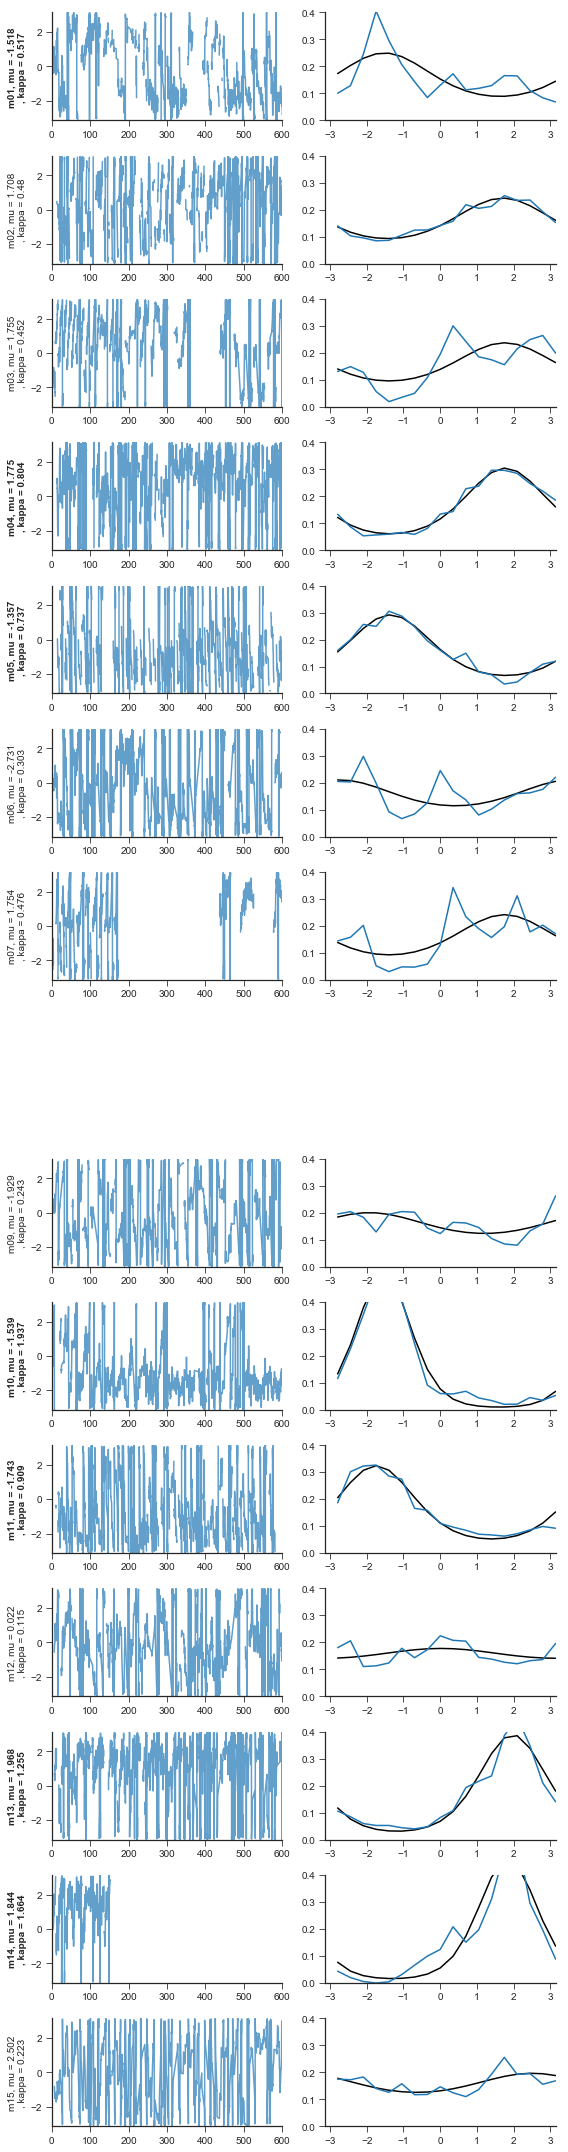

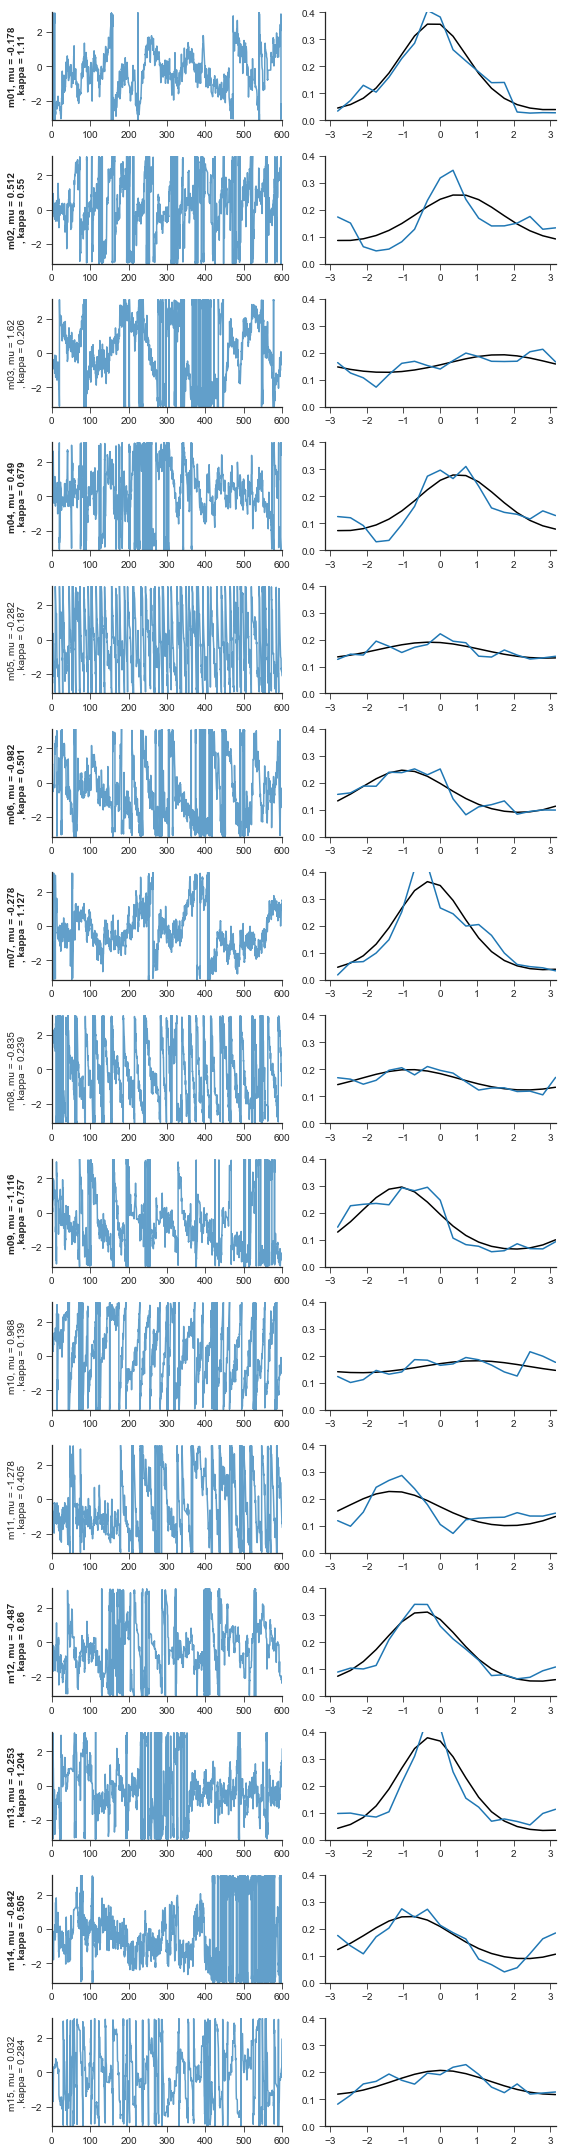

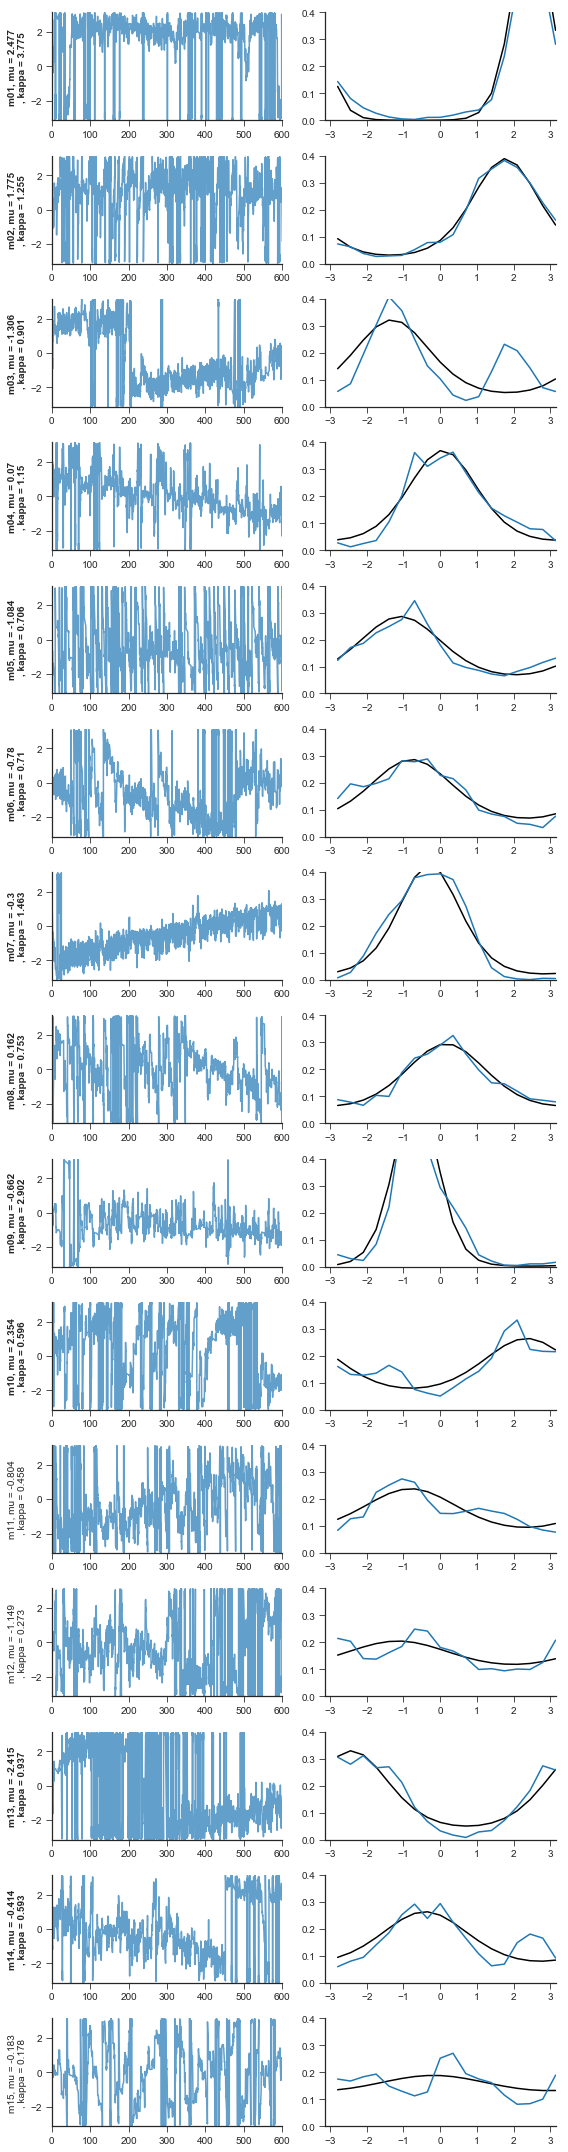

In [163]:
#bins size
binwidth = 20 #deg
numFlies = len(flyIDs)
vmfits = np.nan*np.ones((len(sceneNames),5,numFlies))

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(8,2*numFlies))
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
        scene_df = FOAllFlies_df.query(querystring)
        if len(scene_df) == 0: continue
        nTrial = len(scene_df['moving'].squeeze().astype('int').values)
        if scene_df['trialtype'].values[0] == 'plane':
            scene_df = scene_df.query('LMdist > '+str(minLMdist)+' or LMdist == "NaN"')
            
        moving = scene_df['moving'].values.squeeze().astype('int')
        perFlyG = scene_df['gammaFull'].values.squeeze().astype('float')
        perFlyT = scene_df['time'].values.astype('float')

        if sum(moving)<=0.2*nTrial:
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,nTrial)))
            continue

        gamFul = perFlyG[moving>0]
        time = perFlyT[moving>0]
        
        bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
        x = bins[:-1] + np.mean(np.diff(bins))
        [n,edg] = np.histogram(gamFul,bins=(360/binwidth), range=(angleLow,angleHigh), normed=True)
        meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

        popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
        mu = popt[0]
        kappa = popt[1]
        yhat = vMFunc(x,mu,kappa)

        #compute kolmogorov-smirnov statistic as measure of goodness of fit
        [ks, p] = sts.ks_2samp(n, yhat)

        #compute squared difference from fit
        sqd = np.sum(np.square(n-yhat))

        vmfits[scene,0,fly] = mu
        vmfits[scene,1,fly] = kappa
        vmfits[scene,2,fly] = sqd
        vmfits[scene,3,fly] = p
        vmfits[scene,4,fly] = ks

        #plot fit results
        ax = fitFig.add_subplot(numFlies,2,1+fly*2)
        ax.plot(time, gamFul,alpha=0.7)
        ax.set_xlim(0,600)
        ax.set_ylim(angleLow,angleHigh)
        if(kappa>kappaTH):
            ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)),   fontweight = 'bold')
        else:
            ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))

        myAxisTheme(ax)

        ax = fitFig.add_subplot(numFlies,2,2+fly*2)
        ax.plot(x,yhat,'k')
        ax.plot(x,n)
        ax.set_ylim(0,0.4)
        ax.set_xlim(angleLow,angleHigh)
        myAxisTheme(ax)

    fitFig.tight_layout()

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFit_n'+ str(numFlies) +'.pdf', format='pdf') 

1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m01', 'm04', 'm06', 'm08', 'm13']
flies with large summed squared error:
[]
inverted1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m12']
flies with large summed squared error:
[]


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


BlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
[]
flies with large summed squared error:
[]
WhiteOnBlack
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m01', 'm15']
flies with large summed squared error:
['m03']


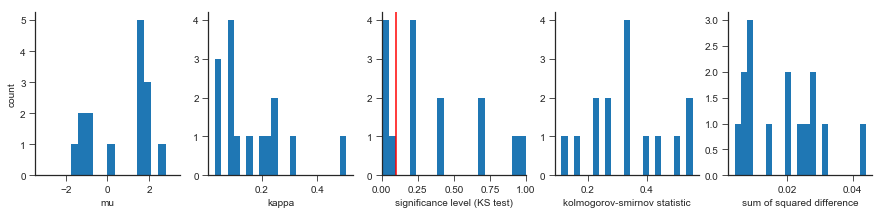

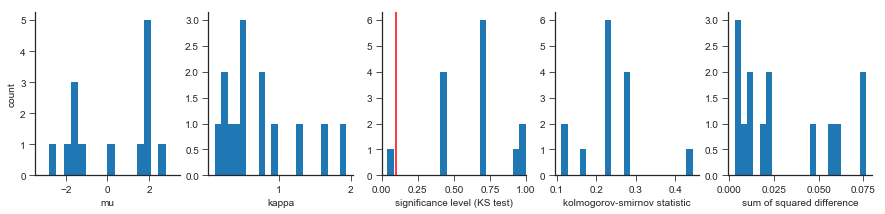

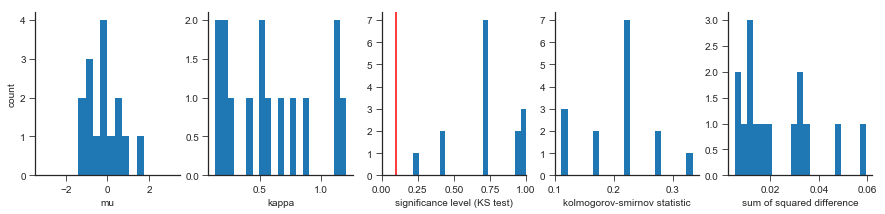

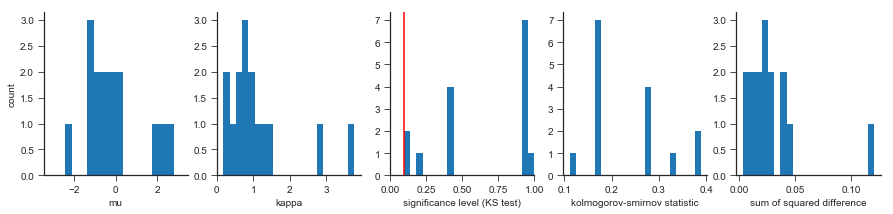

In [164]:
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(15,3))

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    muax = fitFig.add_subplot(151)
    muax.hist(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins)
    muax.set_ylabel('count')
    muax.set_xlabel('mu')
    myAxisTheme(muax)

    bins = np.linspace(0, 2, 21)
    kapax = fitFig.add_subplot(152)
    kapax.hist(vmfits[scene,1,~np.isnan(vmfits[scene,1,:])],len(bins))
    kapax.set_xlabel('kappa')
    myAxisTheme(kapax)

    bins = np.linspace(0, 1, 21)
    pax = fitFig.add_subplot(153)
    pax.hist(vmfits[scene,3,~np.isnan(vmfits[scene,3,:])],len(bins))
    pax.set_xlim(0, 1)
    pax.axvline(0.1,color='red')
    pax.set_xlabel('significance level (KS test)')

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(154)
    ksax.hist(vmfits[scene,4,~np.isnan(vmfits[scene,4,:])],len(bins))
    ksax.set_xlabel('kolmogorov-smirnov statistic')
    myAxisTheme(ksax)

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(155)
    ksax.hist(vmfits[scene,2,~np.isnan(vmfits[scene,2,:])],len(bins))
    ksax.set_xlabel('sum of squared difference')
    myAxisTheme(ksax)

    print(sceneName)
    print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
    print([flyIDs[fly] for fly in np.where(vmfits[scene,3,:]<=0.1)[0]])

    print('flies with large summed squared error:')
    print([flyIDs[fly] for fly in np.where(vmfits[scene,2,:]>=0.08)[0]])

    myAxisTheme(pax)

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


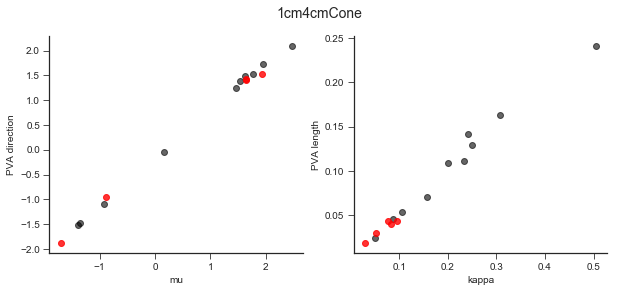

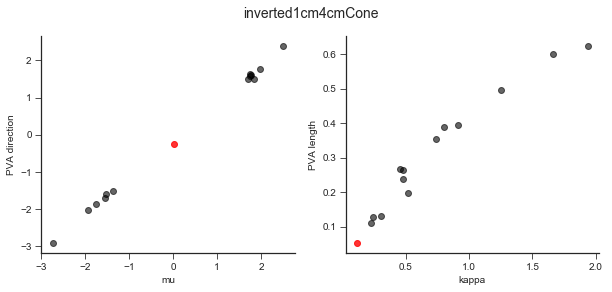

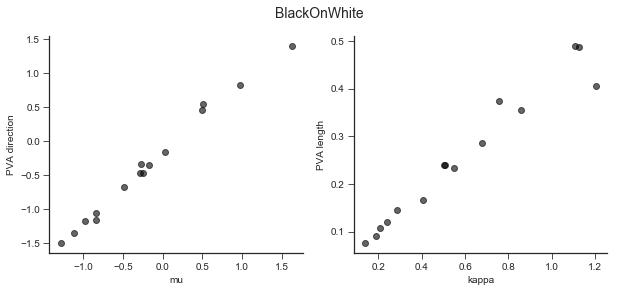

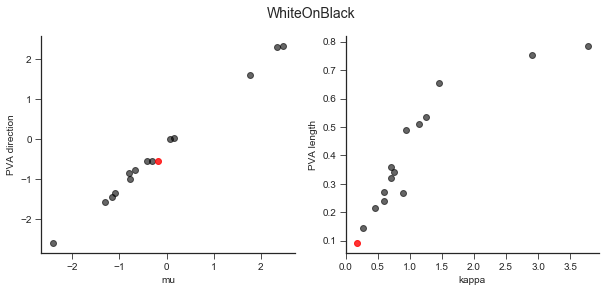

In [165]:
# Correlation between von Mieses fit and PVA
#Plot fit results
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    corrFig = plt.figure(figsize=(10,4))
    corrFig.suptitle(sceneName,fontsize=14)

    notFit = np.logical_and(np.logical_and(vmfits[scene,3,:]<=0.1, headingPVA[scene,:,1]<0.5),\
                            ~np.isnan(headingPVA[scene,:,1]))

    #correlation between mu and PVA direction
    muax = corrFig.add_subplot(121)
    muax.plot(vmfits[scene,0,~notFit],headingPVA[scene,~notFit,0],'ko',alpha=0.6)
    muax.plot(vmfits[scene,0,notFit],headingPVA[scene,notFit,0],'ro',alpha=0.8)
    muax.set_xlabel('mu'); muax.set_ylabel('PVA direction');
    myAxisTheme(muax)

    #correlation between kappa and PVA length
    kapax = corrFig.add_subplot(122)
    kapax.plot(vmfits[scene,1,~notFit],headingPVA[scene,~notFit,1],'ko',alpha=0.6)
    kapax.plot(vmfits[scene,1,notFit],headingPVA[scene,notFit,1],'ro',alpha=0.8)
    kapax.set_xlabel('kappa'); kapax.set_ylabel('PVA length');
    myAxisTheme(kapax)

    corrFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vM-vs-PVA_n'+ str(numFlies) +'.pdf', format='pdf') 

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


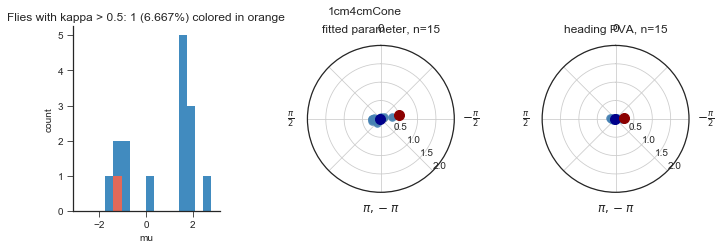

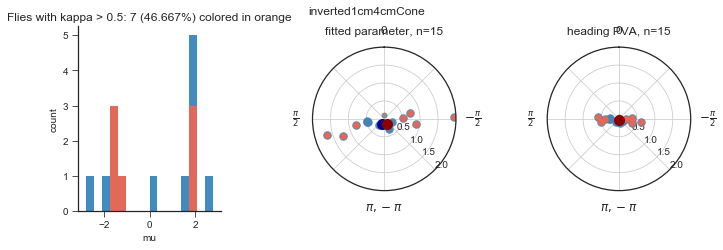

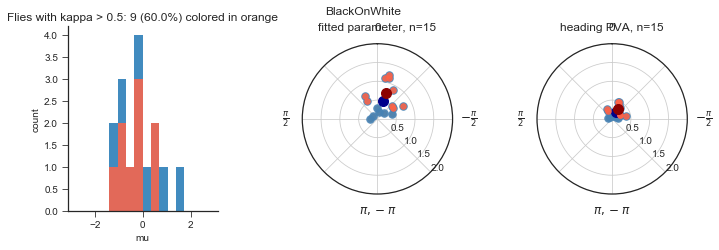

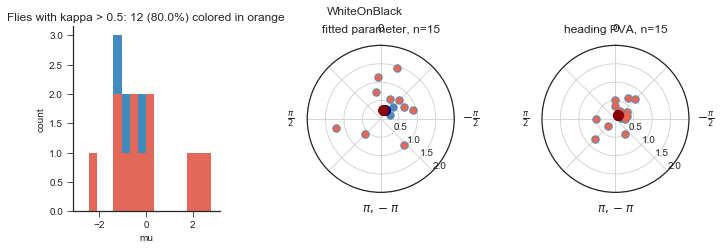

In [166]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))

    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    x = bins[:-1] + np.mean(np.diff(bins))
    [n,edg] = np.histogram(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins)
    [n_slct,edg] = np.histogram(vmfits[scene,0,slct],bins)

    #Plot fit results
    fixFig = plt.figure(figsize=(10,3.5))
    fixFig.suptitle(sceneName,fontsize=12)

    #histogram of fitted location (mu)
    muax = fixFig.add_subplot(131)
    muax.hist(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins,alpha=0.85)
    muax.hist(vmfits[scene,0,slct],bins,color='tomato',alpha=0.85)
    muax.set_xlim(-np.pi, np.pi)
    muax.set_xlabel('mu')
    muax.set_ylabel('count')
    muax.set_title('Flies with kappa > '+str(kappaTH)+': '+str(sum(vmfits[scene,1,:]>kappaTH))+' ('+\
                   str(round(100.0*sum(vmfits[scene,1,:]>kappaTH)/float(numFlies),3))+'%) colored in orange')
    myAxisTheme(muax)
    
    #polar plot of fitted location and shape parameter
    ax = fixFig.add_subplot(132,projection='polar')
    polarHeadingPlot('fitted parameter, n='+str(numFlies),ax, vmfits[scene,0,:],vmfits[scene,1,:],'grey',10,0.85)
    ax.plot(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit],'.',markersize=15,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'.',markersize=11,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,2)

    #polar plot of PVA
    ax = fixFig.add_subplot(133,projection='polar')
    polarHeadingPlot('heading PVA, n='+str(numFlies),ax,headingPVA[scene,:,0],headingPVA[scene,:,1],'grey',10,0.85)
    ax.plot(headingPVA[scene,goodFit,0],headingPVA[scene,goodFit,1],'.',markersize=15,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,:,0],headingPVA[scene,:,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    ax.plot(headingPVA[scene,slct,0],headingPVA[scene,slct,1],'.',markersize=11,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,slct,0],headingPVA[scene,slct,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,2)
    
    fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFixation_n'+ str(numFlies) +'.pdf', format='pdf') 

### Fit bimodal von Mises to those distributions for which no good unimodal fit was found

1cm4cmCone
m01
m04
m06
m08
m13
inverted1cm4cmCone
m12


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


BlackOnWhite
WhiteOnBlack
m15


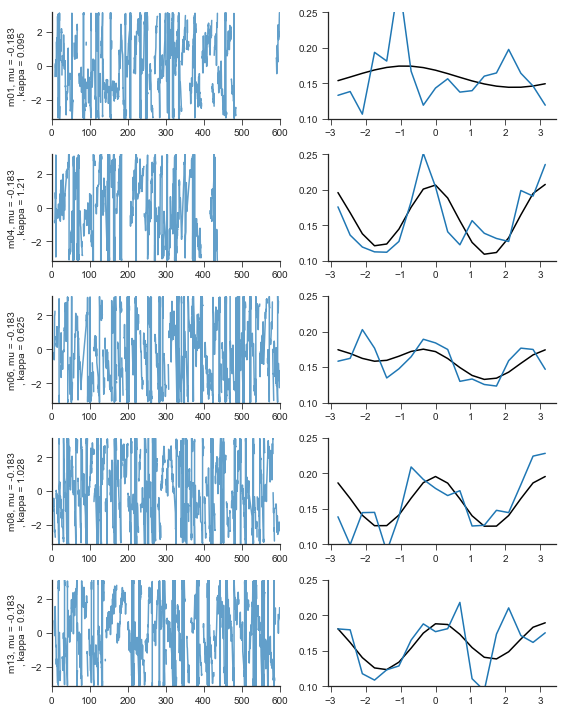

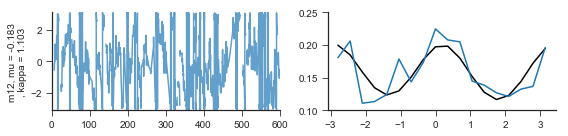

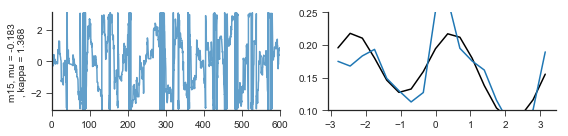

In [167]:
#bins size
binwidth = 20 #deg
numFlies = len(flyIDs)
vmbmfits = np.nan*np.ones((len(sceneNames),6,numFlies))

for scene, sceneName in enumerate(sceneNames):
    print(sceneName)
    
    noFit = np.logical_and(np.logical_and(vmfits[scene,3,:]<=0.1, headingPVA[scene,:,1]<0.5),\
                             ~np.isnan(headingPVA[scene,:,1]))
    
    notGoodFit = np.where(noFit>0)[0]
    if(len(notGoodFit)==0):
        continue
    
    fitFig = plt.figure(figsize=(8,2*len(notGoodFit)))
    
    for ind, fly in enumerate(notGoodFit):
        print(flyIDs[fly])
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
        scene_df = FOAllFlies_df.query(querystring)
        if scene_df['trialtype'].values[0] == 'plane':
            scene_df = scene_df.query('LMdist > '+str(minLMdist)+' or LMdist == "NaN"')
            
        moving = scene_df['moving'].values.squeeze().astype('int')
        perFlyG = scene_df['gammaFull'].values.squeeze().astype('float')
        perFlyT = scene_df['time'].values.astype('float')
       
        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))
            continue

        gamFul = perFlyG[moving>0]
        time = perFlyT[moving>0]

        bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
        x = bins[:-1] + np.mean(np.diff(bins))
        [n,edg] = np.histogram(gamFul,bins = 360/binwidth, range=(angleLow,angleHigh), normed=True)
        meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

        mu01 = np.nanmax(n)
        mu02 = np.mod(mu01+2*np.pi,2*np.pi)-np.pi
        
        popt, pcov = curve_fit(vMbiModFunc, x, n, p0=[mu01,mu02,meanlen_freq],\
                               bounds=([-np.pi, -np.pi, 0], [np.pi, np.pi, np.inf]))
        mu1 = popt[0]
        mu2 = popt[1]
        kappa = popt[2]
        yhat = vMbiModFunc(x,mu1,mu2,kappa)

        #compute kolmogorov-smirnov statistic as measure of goodness of fit
        [ks, p] = sts.ks_2samp(n, yhat)

        #compute squared difference from fit
        sqd = np.sum(np.square(n-yhat))

        vmbmfits[scene,0,fly] = mu1
        vmbmfits[scene,1,fly] = mu2
        vmbmfits[scene,2,fly] = kappa
        vmbmfits[scene,3,fly] = sqd
        vmbmfits[scene,4,fly] = p
        vmbmfits[scene,5,fly] = ks

        #plot fit results
        ax = fitFig.add_subplot(len(notGoodFit),2,1+ind*2)
        ax.plot(time, gamFul,alpha=0.7)
        ax.set_xlim(0,600)
        ax.set_ylim(angleLow,angleHigh)
        ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))
        myAxisTheme(ax)

        ax = fitFig.add_subplot(len(notGoodFit),2,2+ind*2)
        ax.plot(x,yhat,'k')
        ax.plot(x,n)
        ax.set_ylim(angleLow,angleHigh)
        ax.set_ylim(0.1,0.25)
        myAxisTheme(ax)

        fitFig.tight_layout()

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMbiModFit_n'+ str(numFlies) +'.pdf', format='pdf') 

1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m01']


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less_equal


inverted1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
[]
BlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
[]
WhiteOnBlack
flies with heading distribution that is significantly different from von Mieses fit (KS test):
[]


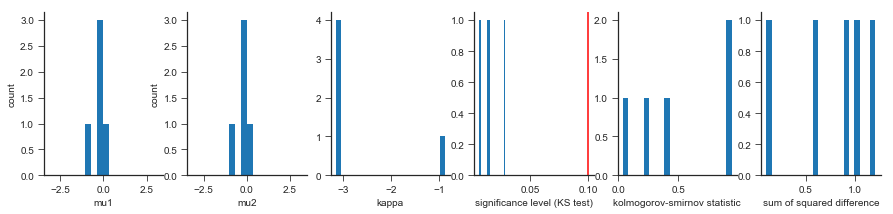

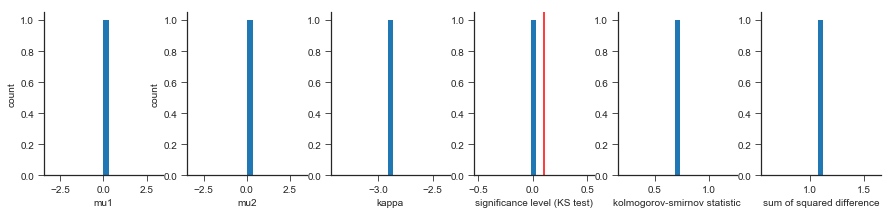

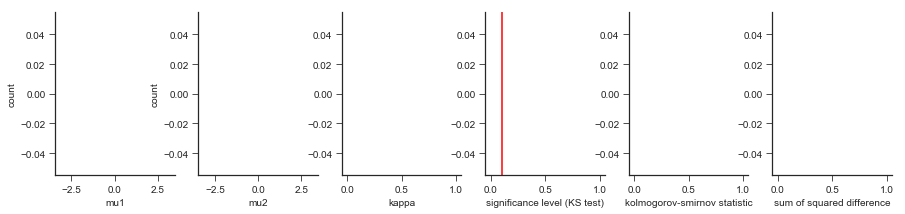

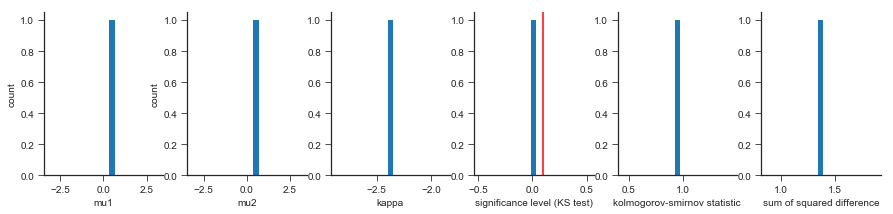

In [168]:
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(15,3))

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    muax = fitFig.add_subplot(161)
    muax.hist(vmbmfits[scene,0,~np.isnan(vmbmfits[scene,0,:])],bins)
    muax.set_ylabel('count')
    muax.set_xlabel('mu1')
    myAxisTheme(muax)
    
    muax = fitFig.add_subplot(162)
    muax.hist(vmbmfits[scene,0,~np.isnan(vmbmfits[scene,1,:])],bins)
    muax.set_ylabel('count')
    muax.set_xlabel('mu2')
    myAxisTheme(muax)

    bins = np.linspace(0, 2, 21)
    kapax = fitFig.add_subplot(163)
    kapax.hist(vmbmfits[scene,1,~np.isnan(vmbmfits[scene,2,:])],len(bins))
    kapax.set_xlabel('kappa')
    myAxisTheme(kapax)

    bins = np.linspace(0, 1, 21)
    pax = fitFig.add_subplot(164)
    pax.hist(vmbmfits[scene,3,~np.isnan(vmbmfits[scene,4,:])],len(bins))
    #pax.set_xlim(0, 1)
    pax.axvline(0.1,color='red')
    pax.set_xlabel('significance level (KS test)')

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(165)
    ksax.hist(vmbmfits[scene,4,~np.isnan(vmbmfits[scene,5,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('kolmogorov-smirnov statistic')
    myAxisTheme(ksax)

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(166)
    ksax.hist(vmbmfits[scene,2,~np.isnan(vmbmfits[scene,3,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('sum of squared difference')
    myAxisTheme(ksax)

    print(sceneName)
    print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
    print([flyIDs[fly] for fly in np.where(vmbmfits[scene,4,:]<=0.1)[0]])

    myAxisTheme(pax)

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMbiModFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


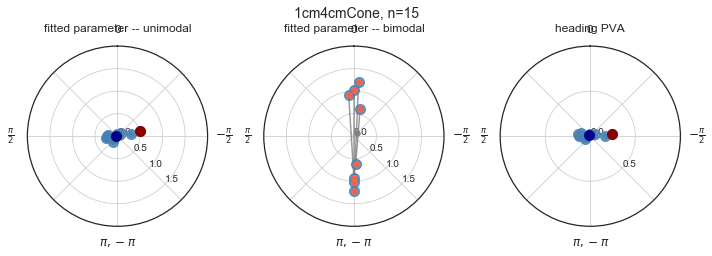

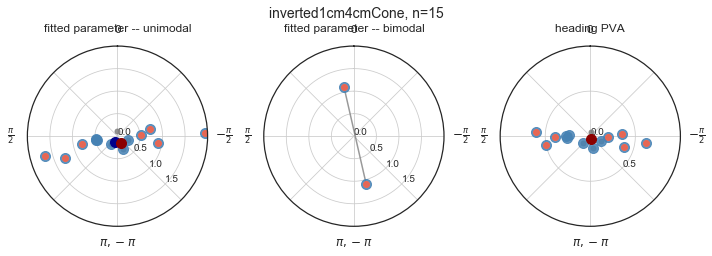

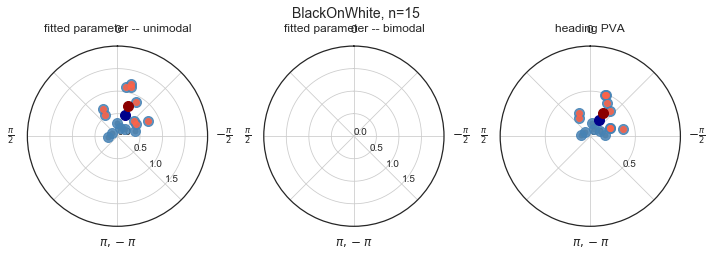

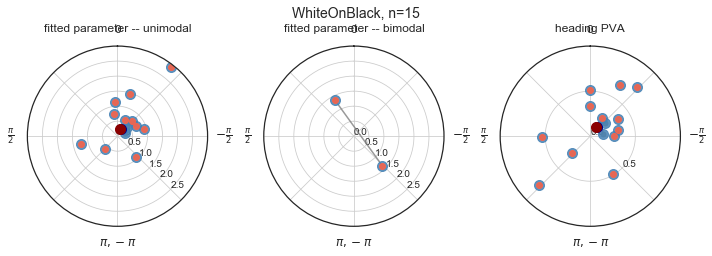

In [169]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

rlims = [2,2,2,3]
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)

    #Plot fit results
    fixFig = plt.figure(figsize=(10,3.75))
    fixFig.suptitle(sceneName+', n='+str(numFlies),fontsize=14)

    #polar plot of fitted location and shape parameter - unimodal
    ax = fixFig.add_subplot(131,projection='polar')
    polarHeadingPlot('fitted parameter -- unimodal',ax, vmfits[scene,0,:],vmfits[scene,1,:],'grey',10,0.85)
    ax.plot(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,rlims[scene])
    ax.set_yticks(np.linspace(0,rlims[scene], 2*rlims[scene], endpoint=False))
    
    #polar plot of fitted location and shape parameter - bimodal
    ax = fixFig.add_subplot(132,projection='polar')
    polarHeadingPlot('fitted parameter -- bimodal',ax, vmbmfits[scene,0,:],vmbmfits[scene,2,:],'grey',10,0.85)
    ax.plot(vmbmfits[scene,1,:],vmbmfits[scene,2,:],'.',markersize=10,color='grey',alpha=0.85)
    ax.plot([vmbmfits[scene,0,:],vmbmfits[scene,1,:]],[vmbmfits[scene,2,:],vmbmfits[scene,2,:]],'-',color='grey',alpha=0.8)
    ax.plot(vmbmfits[scene,0,goodFit_bm],vmbmfits[scene,2,goodFit_bm],'o',markersize=10,color='steelblue',alpha=0.85)
    ax.plot(vmbmfits[scene,1,goodFit_bm],vmbmfits[scene,2,goodFit_bm],'o',markersize=10,color='steelblue',alpha=0.85)
    ax.plot(vmbmfits[scene,0,slct_bm],vmbmfits[scene,2,slct_bm],'.',markersize=12,color='tomato',alpha=0.85)
    ax.plot(vmbmfits[scene,1,slct_bm],vmbmfits[scene,2,slct_bm],'.',markersize=12,color='tomato',alpha=0.85)
    ax.set_rlim(0,rlims[scene])
    ax.set_yticks(np.linspace(0,rlims[scene], 2*rlims[scene], endpoint=False))
    
    #polar plot of PVA
    ax = fixFig.add_subplot(133,projection='polar')
    polarHeadingPlot('heading PVA',ax, headingPVA[scene,:,0],headingPVA[scene,:,1],'grey',10,0.85)
    ax.plot(headingPVA[scene,goodFit,0],headingPVA[scene,goodFit,1],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,:,0],headingPVA[scene,:,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    ax.plot(headingPVA[scene,slct,0],headingPVA[scene,slct,1],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,slct,0],headingPVA[scene,slct,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,1)
    ax.set_yticks(np.linspace(0,1, 2, endpoint=False))
    
    fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMBiModFixation_n'+ str(numFlies) +'.pdf', format='pdf') 
    
    np.savetxt(analysisDir + 'circStats/'  + genotype + '_vMFixation_'+sceneName+'_n'+ str(numFlies) +'.csv',
           np.c_[vmfits[scene,0,:],vmfits[scene,1,:],goodFit,
            vmbmfits[scene,0,:],vmbmfits[scene,1,:],vmbmfits[scene,2,:],goodFit_bm],
            delimiter=',', header='mu,kappa,gof,mu1_bm,mu2_bm,kappa_bm,gof_bm')
    

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


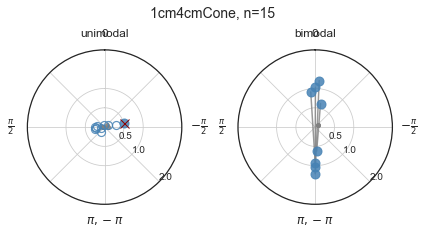

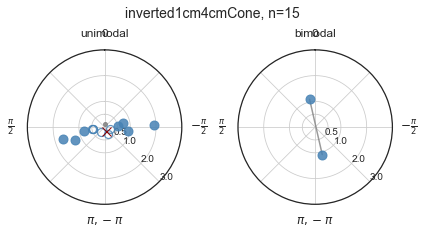

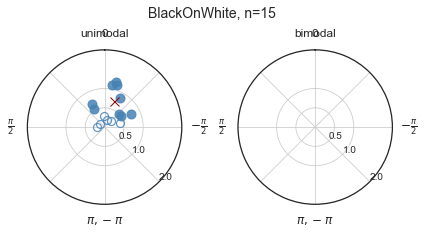

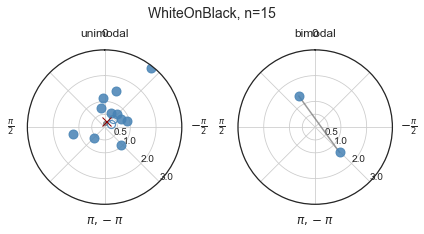

In [170]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

sceneYLim = [2,3,2,3]

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    gfplt = np.logical_and(goodFit, ~slct)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)
    gfplt_bm = np.logical_and(goodFit_bm, ~slct_bm)

    #Plot fit results
    fixFig = plt.figure(figsize=(6,3.5))
    fixFig.suptitle(sceneName+', n='+str(numFlies),fontsize=14)

    #polar plot of fitted location and shape parameter - unimodal
    ax = fixFig.add_subplot(121,projection='polar')
    polarHeadingPlot('unimodal',ax,vmfits[scene,0,~goodFit],vmfits[scene,1,~goodFit],'grey',8,0.85)
    ax.plot(vmfits[scene,0,gfplt],vmfits[scene,1,gfplt],'o',markeredgecolor='steelblue',
            markerfacecolor='none',  markeredgewidth=1.2, markersize = 8,alpha=0.85)
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'o',markersize=9,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'x', color='darkred',alpha=1, markersize=9)
    ax.set_yticks([0.5, 1, 2, 3])
    ax.set_ylim(0, sceneYLim[scene])
    
    #polar plot of fitted location and shape parameter - bimodal
    ax = fixFig.add_subplot(122,projection='polar')
    polarHeadingPlot('bimodal',ax,vmbmfits[scene,0,~goodFit_bm],vmbmfits[scene,2,~goodFit_bm],'grey',8,0.85)
    ax.plot(vmbmfits[scene,1,~goodFit_bm],vmbmfits[scene,2,~goodFit_bm],'.',markersize=8,color='grey',alpha=0.85)
    ax.plot([vmbmfits[scene,0,goodFit_bm],vmbmfits[scene,1,goodFit_bm]],
            [vmbmfits[scene,2,goodFit_bm],vmbmfits[scene,2,goodFit_bm]],'-',color='grey',alpha=0.8)
    ax.plot(vmbmfits[scene,0,gfplt_bm],vmbmfits[scene,2,gfplt_bm],'o',color='steelblue',markerfacecolor='none', 
            markeredgewidth=1.2, markersize = 8,alpha=0.85)
    ax.plot(vmbmfits[scene,1,gfplt_bm],vmbmfits[scene,2,gfplt_bm],'o',color='steelblue',markerfacecolor='none', 
            markeredgewidth=1.2, markersize = 8,alpha=0.85)
    ax.plot(vmbmfits[scene,0,slct_bm],vmbmfits[scene,2,slct_bm],'o',markersize=9,color='steelblue',alpha=0.85)
    ax.plot(vmbmfits[scene,1,slct_bm],vmbmfits[scene,2,slct_bm],'o',markersize=9,color='steelblue',alpha=0.85)
    ax.set_yticks([0.5, 1, 2, 3])
    ax.set_ylim(0, sceneYLim[scene])
    
    fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMBiModFixation_n'+ str(numFlies) +'.pdf', format='pdf') 

### Selection of data

In [171]:
print('Total number of flies measured: ' + str(numFlies))

for scene,sceneName in enumerate(sceneNames):
    print('\n'+sceneName)
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)
    
    print('Number of flies that walked for less than 20% of trial time: ' + str(int(fliesNotWalking[scene])) \
          + ' ('+str(numFlies)+')')
    
    print('Unimodal fits:')
    print('  Number of walking flies for which von Mises was good fit: ' + str(sum(goodFit))\
          + ' ('+str(numFlies-int(fliesNotWalking[scene]))+')')
    print('  Total number of fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmfits[scene,1,:]>kappaTH)) + ' ('+str(numFlies-int(fliesNotWalking[scene]))+')')
    print('  Number of well fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmfits[scene,1,goodFit]>kappaTH)) + ' ('+str(sum(goodFit))+')')

    print('Bimodal fits:')
    print('  Number of walking flies for which bimodal von Mises was good fit: ' + str(sum(goodFit_bm))\
          + ' ('+str(sum(~goodFit)-int(fliesNotWalking[scene]))+')')
    print('  Number of well fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmbmfits[scene,2,goodFit_bm]>kappaTH)) + ' ('+str(sum(goodFit_bm))+')')

Total number of flies measured: 15

1cm4cmCone
Number of flies that walked for less than 20% of trial time: 0 (15)
Unimodal fits:
  Number of walking flies for which von Mises was good fit: 10 (15)
  Total number of fitted distributions with concentration measure kappa > 0.5: 1 (15)
  Number of well fitted distributions with concentration measure kappa > 0.5: 1 (10)
Bimodal fits:
  Number of walking flies for which bimodal von Mises was good fit: 4 (5)
  Number of well fitted distributions with concentration measure kappa > 0.5: 4 (4)

inverted1cm4cmCone
Number of flies that walked for less than 20% of trial time: 0 (15)
Unimodal fits:
  Number of walking flies for which von Mises was good fit: 13 (15)
  Total number of fitted distributions with concentration measure kappa > 0.5: 7 (15)
  Number of well fitted distributions with concentration measure kappa > 0.5: 7 (13)
Bimodal fits:
  Number of walking flies for which bimodal von Mises was good fit: 1 (2)
  Number of well fitted distr

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


### Use Rayleigh test on mean fixation location (on selected data, conditioned on good fit with unimodal von Mises)

In [172]:
# ...based on on fitted location parameter mu

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    print('\n'+sceneName)
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)

    fitSamples = len(vmfits[scene,0,slct])
    
    PVAdir, PVAlen = circmeanvec(vmfits[scene,0,slct],np.ones(fitSamples), high=angleHigh, low=angleLow)

    [z,p] = RayleighTest(PVAlen,fitSamples)

    print('Test statistic z = ' + str(z))
    print('Probability of test statistic p = ' + str(p))
    if (p<0.001):
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.001).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    elif (p<0.01): 
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.01).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    elif (p<0.05): 
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.05).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    else:
        print('Accept H0 that sample is drawn from a uniform distribution (p>0.01).')


1cm4cmCone
Test statistic z = 1.0
Probability of test statistic p = 0.465831162611
Accept H0 that sample is drawn from a uniform distribution (p>0.01).

inverted1cm4cmCone
Test statistic z = 0.248436800793
Probability of test statistic p = 0.791603384912
Accept H0 that sample is drawn from a uniform distribution (p>0.01).

BlackOnWhite
Test statistic z = 6.5796806199
Probability of test statistic p = 0.000386426676835
Reject H0 that sample is drawn from a uniform distribution (p<0.001).
Mean angle = -0.356 (-20.418 deg)

WhiteOnBlack
Test statistic z = 1.43563832426
Probability of test statistic p = 0.242088245681
Accept H0 that sample is drawn from a uniform distribution (p>0.01).


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


### Visualise performance with bar plot

1cm4cmCone


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


inverted1cm4cmCone
BlackOnWhite
WhiteOnBlack


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


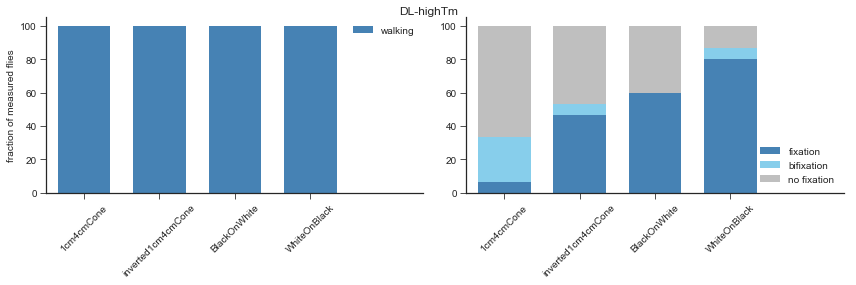

In [173]:
fixBarFig, ax  = plt.subplots(1, 2, figsize=(12,4))
width = 0.7
permSceneNames = [sceneNames[1],sceneNames[2],sceneNames[0]]
permscene = [1,2,0]
for scene, scenename in enumerate(sceneNames):
    print(scenename)
    scene
    
    walking = 100.0*(numFlies - int(fliesNotWalking[scene]))/numFlies
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)
    
    fixating = 100.0*sum(vmfits[scene,1,goodFit]>kappaTH)/(numFlies - int(fliesNotWalking[scene]))
    bifixating = 100.0*sum(vmbmfits[scene,2,goodFit_bm]>kappaTH)/(numFlies - int(fliesNotWalking[scene]))
    
    p11 = ax[0].bar(scene, walking, width, color='steelblue', alpha=1)
    
    p21 = ax[1].bar(scene, fixating, width, color='steelblue')
    p22 = ax[1].bar(scene, bifixating, width, bottom=fixating, color='skyblue')
    p23 = ax[1].bar(scene, 100.0-(fixating+bifixating), width, bottom=(fixating+bifixating),
                 color='grey', alpha=0.5)
    
ax[0].legend([p11], ['walking'])
ax[0].set_ylabel('fraction of measured flies')
ax[0].set_xlim(-0.5, len(sceneNames)+0.5)
plt.sca(ax[0])
plt.xticks(range(len(sceneNames)), sceneNames, rotation=45)
myAxisTheme(ax[0])

ax[1].legend([p21, p22, p23], ['fixation','bifixation', 'no fixation'])
ax[1].set_xlim(-0.5, len(sceneNames)+0.5)
plt.sca(ax[1])
plt.xticks(range(len(sceneNames)), sceneNames, rotation=45)
myAxisTheme(ax[1])

fixBarFig.suptitle(genotypeSex)
fixBarFig.tight_layout()

fixBarFig.savefig(analysisDir + 'circStats/'  + genotype +
                   '_fixationBarPlot_n'+ str(numFlies) +'.pdf', format='pdf') 

## Relationship between walking velocity and fixation

1cm4cmCone


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


inverted1cm4cmCone


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


BlackOnWhite
WhiteOnBlack


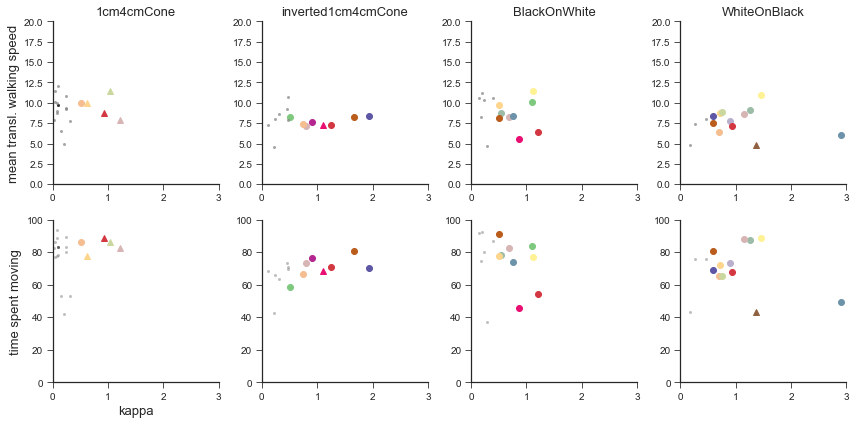

In [174]:
walkingCorr, axs = plt.subplots(2, len(sceneNames), figsize=(12,6))

for scene, sceneName in enumerate(sceneNames):
    print(sceneName)
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                                  ~np.isnan(headingPVA[scene,:,1]))
    goodFit_bm = vmbmfits[scene,4,:]>0.1

    kappasFly = [vmfits[scene,1,:], vmbmfits[scene,2,:]]
    slct = [np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit),
            np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)]

    markerstyle = [('grey', 'o'), ('black','^')]
    
    for fly in range(numFlies):
        querystring = '(flyID == "' + flyIDs[fly] + '" & sceneName == "'+sceneName+'")'
        scene_df = FOAllFlies_df.query(querystring)
        if len(scene_df)==0 : continue
        if scene_df['trialtype'].values[0] == 'plane':
            scene_df = scene_df.query('LMdist > '+str(minLMdist)+' or LMdist == "NaN"')
            
        flyMov = scene_df['moving'].values.squeeze().astype('int')
        flyVT = scene_df['transVelo'].values.astype('float')

        for i in range(2):
            if(len(kappasFly[i])==0): continue
            if(len(flyMov)==0): continue
            if slct[i][fly]:
                axs[0][scene].plot(kappasFly[i][fly], np.nanmean(flyVT[flyMov>0]), markerstyle[i][1], color=flyCMap.to_rgba(fly))
            else:
                axs[0][scene].plot(kappasFly[i][fly], np.nanmean(flyVT[flyMov>0]), '.',
                                   markerfacecolor=markerstyle[i][0], markeredgecolor='none', alpha=.7)

            if slct[i][fly]:
                axs[1][scene].plot(kappasFly[i][fly], 100.*np.sum(flyMov)/len(flyMov), markerstyle[i][1], color=flyCMap.to_rgba(fly))
            else:
                axs[1][scene].plot(kappasFly[i][fly], 100.*np.sum(flyMov)/len(flyMov), '.', 
                                   markerfacecolor=markerstyle[i][0], markeredgecolor='none', alpha=.5) 

    if not scene:
        axs[0,scene].set_ylabel('mean transl. walking speed', fontsize=13)
        axs[1,scene].set_xlabel('kappa', fontsize=13)
        axs[1,scene].set_ylabel('time spent moving', fontsize=13)
    axs[0,scene].set_xlim(0, 3)
    axs[0,scene].set_ylim(0, 20)
    axs[1,scene].set_xlim(0, 3)
    axs[1,scene].set_ylim(0, 100)
    axs[0,scene].set_title(sceneName, fontsize=13)
    [myAxisTheme(axs[i,scene]) for i in range(2)]
    
walkingCorr.tight_layout()
walkingCorr.savefig(analysisDir + 'velocityTraces'+sep+genotype+'_walkingCorr_n'+ str(numFlies)+'.pdf') 

## Comparison between fixation in 1D and 2D
### Is there a correlation between the location of the fixation peak in 1D and 2D?

BlackOnWhite vs 1cm4cmCone
WhiteOnBlack vs inverted1cm4cmCone


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


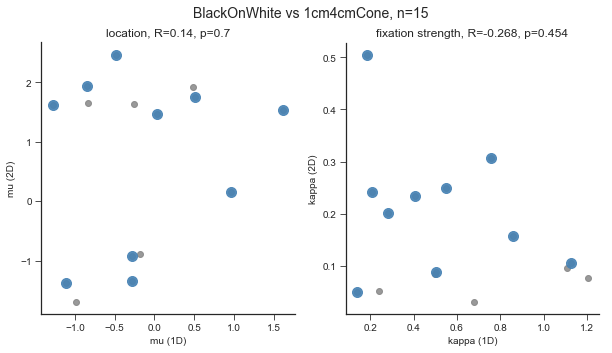

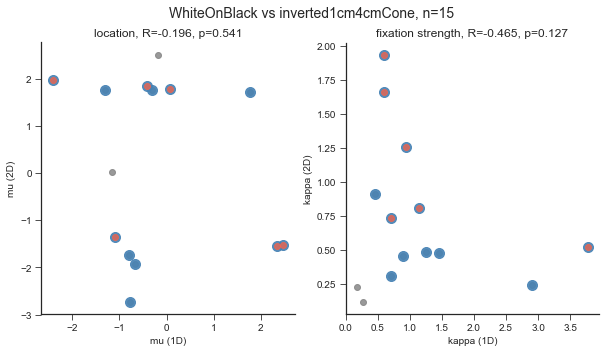

In [175]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

kappaTH = 0.5

groups = [(0,2),(1,3)]

for ind, group in enumerate(groups):
    scene1D = sceneNames[group[1]]
    scene2D = sceneNames[group[0]]
    
    print(scene1D + ' vs ' + scene2D)
    
    #Plot fit results
    fix1Dvs2DFig = plt.figure(figsize=(10,5))
    fix1Dvs2DFig.suptitle(scene1D + ' vs ' + scene2D + ', n='+str(numFlies),fontsize=14)
    
    ## Unimodal
    goodFit1D = np.logical_and(np.logical_or(vmfits[group[1],3,:]>0.1, headingPVA[group[1],:,1]>0.5),\
                              ~np.isnan(headingPVA[group[1],:,1]))
    goodFit2D = np.logical_and(np.logical_or(vmfits[group[0],3,:]>0.1, headingPVA[group[0],:,1]>0.5),\
                              ~np.isnan(headingPVA[group[0],:,1]))
    goodFit = np.logical_and(goodFit1D,goodFit2D)
    
    slct1D = np.logical_and(vmfits[group[1],1,:]>kappaTH,goodFit1D)
    slct2D = np.logical_and(vmfits[group[0],1,:]>kappaTH,goodFit2D)
    slct = np.logical_and(slct1D,slct2D)

    #correlation between fixation location in 1D and 2D
    ax = fix1Dvs2DFig.add_subplot(121)
    ax.plot(vmfits[group[1],0,:],vmfits[group[0],0,:],'o',markersize=6,color='grey',alpha=0.8)
    ax.plot(vmfits[group[1],0,goodFit],vmfits[group[0],0,goodFit],'o',markersize=10,color='steelblue',alpha=0.9)
    ax.plot(vmfits[group[1],0,slct],vmfits[group[0],0,slct],'.',markersize=12,color='tomato',alpha=0.7)
    ax.set_xlabel('mu (1D)')
    ax.set_ylabel('mu (2D)')
    pR, pp = sts.pearsonr(vmfits[group[1],0,goodFit], vmfits[group[0],0,goodFit])
    ax.set_title('location, R='+str(round(pR,3))+', p='+str(round(pp,3)))
    myAxisTheme(ax)
    
    #correlation between fixation strength in 1D and 2D
    ax = fix1Dvs2DFig.add_subplot(122)
    ax.plot(vmfits[group[1],1,:],vmfits[group[0],1,:],'o',markersize=6,color='grey',alpha=0.8)
    ax.plot(vmfits[group[1],1,goodFit],vmfits[group[0],1,goodFit],'o',markersize=10,color='steelblue',alpha=0.9)
    ax.plot(vmfits[group[1],1,slct],vmfits[group[0],1,slct],'.',markersize=12,color='tomato',alpha=0.7)
    ax.set_xlabel('kappa (1D)')
    ax.set_ylabel('kappa (2D)')
    pR, pp = sts.pearsonr(vmfits[group[1],1,goodFit], vmfits[group[0],1,goodFit])
    ax.set_title('fixation strength, R='+str(round(pR,3))+', p='+str(round(pp,3)))
    myAxisTheme(ax)
    
    fix1Dvs2DFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + scene1D + 'Vs' + scene2D
                   + '-Fixation_n'+ str(numFlies) +'.pdf', format='pdf') 

## Intergroup comparison -- uses saved data in csv file

In [380]:
analysisDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/comparativeAnalysisofFixation/'
kappaTH = 0.5

### By group analysis

In [400]:
rootDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/'

groupNames = ['WTB','WTB-highT','WTB-highT-g']
temp = ['lowT','highT','highT']
wings = ['cut','cut','glued']
genotypes = ['WTB','WTB','WTB']
ns = [[26,27],[16,16],[18,19]]
sexs = ['female','male']

sceneNames = ['BlackOnWhite', '1cm4cmCone', 'WhiteOnBlack', 'inverted1cm4cmCone']
sceneDim = ['1D', '2D', '1D', '2D']
contrast = ['darkOnBright', 'darkOnBright', 'brightOnDark', 'brightOnDark']

# For WTB handling: hightT cut, hightT glued, lowT cut
groupCol = [['darkturquoise','mediumaquamarine','teal'],
            ['mediumseagreen','palegreen','darkolivegreen']]

In [401]:
genotypes_df = pd.DataFrame()
keylist_gendf = ['genotype', 'group','wings','temp','sex','scene','contrast','sceneName',
               'trialType','flyID','# mu','kappa','gof','mu1_bm','mu2_bm','kappa_bm','gof_bm'] 

In [402]:
for i, group in enumerate(groupNames):
    for j, scene in enumerate(sceneNames):
        for s, sex in enumerate(sexs):
            path2data = rootDir + group + '/fourConditions/{}/analysis/circStats/'.format(sex)
            subset_df = pd.read_csv(path2data + '{}_vMFixation_{}_n{}.csv'.format(group,scene,ns[i][s]))

            subset_df.insert(0, 'genotype', genotypes[i])
            subset_df.insert(1, 'group', '{}-{}'.format(temp[i],wings[i]))
            subset_df.insert(2, 'wings', wings[i])
            subset_df.insert(3, 'temp', temp[i])
            subset_df.insert(4, 'sex', sex)
            subset_df.insert(5, 'scene', sceneDim[j])
            subset_df.insert(6, 'contrast', contrast[j])
            subset_df.insert(7, 'sceneName', scene)
            subset_df.insert(8, 'trialType', trialtype)
            subset_df.insert(9, 'flyID', range(len(subset_df)))

            genotypes_df = genotypes_df.append(subset_df)

genotypes_df["genotype"] = genotypes_df["genotype"].astype('category')
genotypes_df["wings"] = genotypes_df["wings"].astype('category')
genotypes_df["temp"] = genotypes_df["temp"].astype('category')
genotypes_df["sex"] = genotypes_df["sex"].astype('category')
genotypes_df["scene"] = genotypes_df["scene"].astype('category')
genotypes_df["contrast"] = genotypes_df["contrast"].astype('category')
genotypes_df["sceneName"] = genotypes_df["sceneName"].astype('category')
genotypes_df["group"] = genotypes_df["group"].astype('category')

In [403]:
genotypes_df = genotypes_df[keylist_gendf]
genotypes_df.head()

genotype     group wings  temp     sex scene      contrast     sceneName  \
0      WTB  lowT-cut   cut  lowT  female    1D  darkOnBright  BlackOnWhite   
1      WTB  lowT-cut   cut  lowT  female    1D  darkOnBright  BlackOnWhite   
2      WTB  lowT-cut   cut  lowT  female    1D  darkOnBright  BlackOnWhite   
3      WTB  lowT-cut   cut  lowT  female    1D  darkOnBright  BlackOnWhite   
4      WTB  lowT-cut   cut  lowT  female    1D  darkOnBright  BlackOnWhite   

  trialType  flyID      # mu     kappa  gof  mu1_bm  mu2_bm  kappa_bm  gof_bm  
0    stripe      0 -0.232311  0.200430  1.0     NaN     NaN       NaN     0.0  
1    stripe      1       NaN       NaN  0.0     NaN     NaN       NaN     0.0  
2    stripe      2       NaN       NaN  0.0     NaN     NaN       NaN     0.0  
3    stripe      3       NaN       NaN  0.0     NaN     NaN       NaN     0.0  
4    stripe      4  0.715237  0.925407  1.0     NaN     NaN       NaN     0.0

In [404]:
def stylePolarPlot(titlestr,ax,sceneYLim,ytickvals,scene):
    ax.set_xticklabels(['0','', r'$\frac{\pi}{2}$','', r'$\pi,-\pi$','', r'$-\frac{\pi}{2}$',''],fontsize=12)
    ax.set_title(titlestr)
    ax.set_rlabel_position(135)
    ax.set_xlim(0, 2*np.pi)
    ax.set_yticks(ytickvals)
    ax.set_ylim(0, sceneYLim[scene])
    ax.set_theta_zero_location("N")
    ax.spines['polar'].set_visible(False)

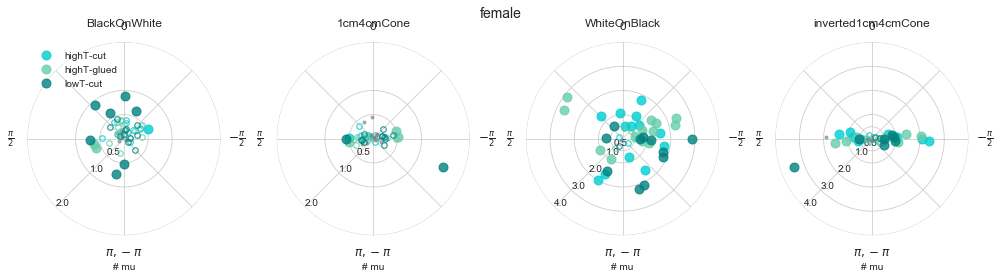

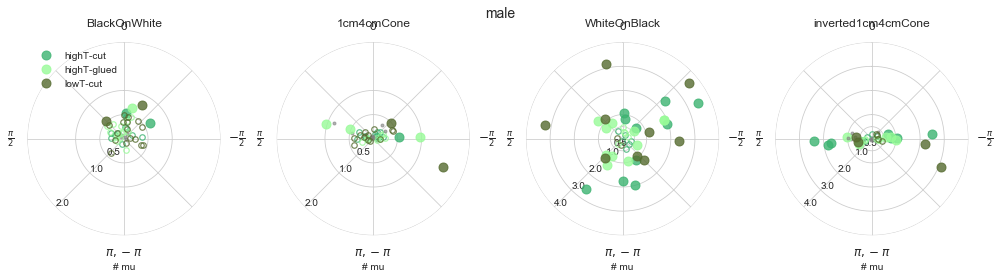

In [405]:
sceneYLim = [2,2,4,4]
ytickvals = [0.5, 1, 2, 3, 4]
for si, sex in enumerate(sexs):
    fixFig = plt.figure(figsize=(14,4))
    fixFig.suptitle(sex,fontsize=14)

    for scene, sceneName in enumerate(sceneNames):
        for groupid, group in enumerate(genotypes_df.group.cat.categories.tolist()):
            #polar plot of fitted location and shape parameter - unimodal
            ax = fixFig.add_subplot(1,4,scene+1, projection='polar')
            currdf = genotypes_df.query('sceneName=="{}" & sex=="{}" & group=="{}"'.format(sceneName,sex,group))
            notgof_df = currdf.query('gof == 0 & kappa >=0')
            if not notgof_df.empty:
                notgof_df.plot(ax=ax, x="# mu", y="kappa",color='grey', marker='.',
                              alpha=0.6, linestyle='none', grid=True, label='')
            
            gof_df = currdf.query('gof == 1 & kappa < '+str(kappaTH))
            if not gof_df.empty:
                gof_df.plot(ax=ax, x="# mu", y="kappa", 
                            color=groupCol[si][groupid], marker='.',
                           alpha=0.8, markerfacecolor='none',  markeredgewidth=1.2, markersize = 11,
                            linestyle='none',grid=True, label='')
            
            fix_df = currdf.query('gof == 1 & kappa >= '+str(kappaTH))
            if not fix_df.empty:
                if scene== 0:
                    fix_df.plot(ax=ax, x="# mu", y="kappa", color=groupCol[si][groupid], marker='o',
                                markersize = 9, alpha=0.8, linestyle='none', grid=True, label=group)
                else:
                    fix_df.plot(ax=ax, x="# mu", y="kappa", color=groupCol[si][groupid], marker='o',
                                markersize = 9, alpha=0.8, linestyle='none', grid=True, label='')
                               
            stylePolarPlot(sceneName,ax,sceneYLim,ytickvals,scene)
            
            ax.legend(loc=2)
        
    fixFig.tight_layout()
    fixFig.savefig(analysisDir+ '/WTB_vMFixation_allData_' + sex+ '_uniModalFixation.pdf', format='pdf') 

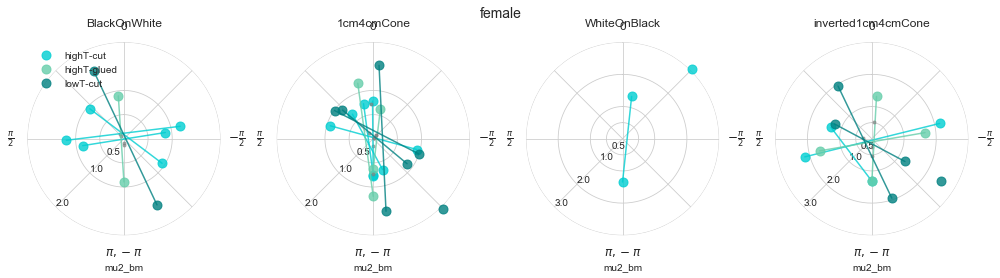

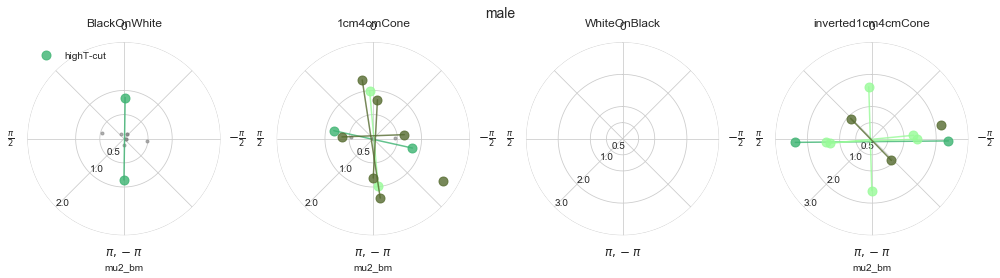

In [406]:
sceneYLim = [2,2,3,3]
ytickvals = [0.5, 1, 2, 3, 4]

for si, sex in enumerate(sexs):
    fixFig = plt.figure(figsize=(14,4))
    fixFig.suptitle(sex,fontsize=14)

    for sc, sceneName in enumerate(sceneNames):
        
        for groupid, group in enumerate(genotypes_df.group.cat.categories.tolist()):
            #polar plot of fitted location and shape parameter - unimodal
            ax = fixFig.add_subplot(1,4,sc+1, projection='polar')
            currdf = genotypes_df.query('sceneName=="{}" & sex=="{}" & group=="{}"'.format(sceneName,sex,group))
            notgof_df = currdf.query('gof_bm == 0 & kappa_bm >=0')
            
            if not notgof_df.empty:
                notgof_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", color='grey', marker='.',
                                alpha=0.6, linestyle='none', grid=True, label='')
                notgof_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color='grey', marker='.',
                                alpha=0.6, linestyle='none', grid=True, label='')
            
            gof_df = currdf.query('gof_bm == 1 & kappa_bm < '+str(kappaTH))
            if not gof_df.empty:
                gof_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", markeredgecolor=groupCol[si][groupid], marker='o',
                            alpha=0.8, markerfacecolor='none',  markeredgewidth=1.2, markersize = 11,
                            linestyle='none',grid=True, label='')
                gof_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", markeredgecolor=groupCol[si][groupid], marker='o',
                            alpha=0.8, markerfacecolor='none',  markeredgewidth=1.2, markersize = 11,
                            linestyle='none',grid=True, label='')
            
            fix_df = currdf.query('gof_bm == 1 & kappa_bm >= '+str(kappaTH))
            if not fix_df.empty:
                try:
                    x = [fix_df["mu1_bm"].values, fix_df["mu2_bm"].values]
                    y = [fix_df["kappa_bm"].values, fix_df["kappa_bm"].values]
                    ax.plot(x,y,alpha=0.8, color=groupCol[si][groupid], linewidth=1.5,label='')
                except KeyError:
                    print("KeyError " + group)
                    print(x)
                    
                fix_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", color=groupCol[si][groupid], marker='o',
                            markersize = 9, alpha=0.8, linestyle='none', grid=True,label='')
                if sc == 0:
                    fix_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color=groupCol[si][groupid], marker='o',
                                markersize = 9, alpha=0.8, linestyle='none', grid=True,label=group)
                else:
                    fix_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color=groupCol[si][groupid], marker='o',
                                markersize = 9, alpha=0.8, linestyle='none', grid=True,label='')

        stylePolarPlot(sceneName,ax,sceneYLim,ytickvals,sc)
        ax.legend(loc=2)
        
    fixFig.tight_layout()
    fixFig.savefig(analysisDir+ '/WTB_vMFixation_allData_' + sex + '_biModalFixation.pdf', format='pdf') 

### By genotype analysis

In [407]:
rootDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/FlyOver095_lowContrast/stripetracking/'

groupNames = ['DL-highT','WTB-highT','WTBhybrid-highT']
temp = ['highT','highT','highT']
wings = ['cut','cut','cut']
genotypes = ['DL','WTB','WTBhybrid']
ns = [[15,15],[16,16],[25,25]]
sexs = ['female','male']

sceneNames = ['BlackOnWhite', '1cm4cmCone', 'WhiteOnBlack', 'inverted1cm4cmCone']
sceneDim = ['1D', '2D', '1D', '2D']
contrast = ['darkOnBright', 'darkOnBright', 'brightOnDark', 'brightOnDark']

# For genotype comparison: DL, WTB, WTB hybrid (all hightT, cut) -- male/female
groupCol = [['tomato','darkturquoise','royalblue'],
            ['indianred','mediumseagreen','slateblue']]

In [408]:
genotypes_df = pd.DataFrame()
keylist_gendf = ['genotype', 'group','wings','temp','sex','scene','contrast','sceneName',
               'trialType','flyID','# mu','kappa','gof','mu1_bm','mu2_bm','kappa_bm','gof_bm'] 

In [409]:
for i, group in enumerate(groupNames):
    for j, scene in enumerate(sceneNames):
        for s, sex in enumerate(sexs):
            path2data = rootDir + group + '/fourConditions/{}/analysis/circStats/'.format(sex)
            subset_df = pd.read_csv(path2data + '{}_vMFixation_{}_n{}.csv'.format(group,scene,ns[i][s]))

            subset_df.insert(0, 'genotype', genotypes[i])
            subset_df.insert(1, 'group', '{}-{}'.format(temp[i],wings[i]))
            subset_df.insert(2, 'wings', wings[i])
            subset_df.insert(3, 'temp', temp[i])
            subset_df.insert(4, 'sex', sex)
            subset_df.insert(5, 'scene', sceneDim[j])
            subset_df.insert(6, 'contrast', contrast[j])
            subset_df.insert(7, 'sceneName', scene)
            subset_df.insert(8, 'trialType', trialtype)
            subset_df.insert(9, 'flyID', range(len(subset_df)))

            genotypes_df = genotypes_df.append(subset_df)

genotypes_df["genotype"] = genotypes_df["genotype"].astype('category')
genotypes_df["wings"] = genotypes_df["wings"].astype('category')
genotypes_df["temp"] = genotypes_df["temp"].astype('category')
genotypes_df["sex"] = genotypes_df["sex"].astype('category')
genotypes_df["scene"] = genotypes_df["scene"].astype('category')
genotypes_df["contrast"] = genotypes_df["contrast"].astype('category')
genotypes_df["sceneName"] = genotypes_df["sceneName"].astype('category')
genotypes_df["group"] = genotypes_df["group"].astype('category')

In [410]:
genotypes_df.head()

genotype      group wings   temp     sex scene      contrast     sceneName  \
0       DL  highT-cut   cut  highT  female    1D  darkOnBright  BlackOnWhite   
1       DL  highT-cut   cut  highT  female    1D  darkOnBright  BlackOnWhite   
2       DL  highT-cut   cut  highT  female    1D  darkOnBright  BlackOnWhite   
3       DL  highT-cut   cut  highT  female    1D  darkOnBright  BlackOnWhite   
4       DL  highT-cut   cut  highT  female    1D  darkOnBright  BlackOnWhite   

  trialType  flyID      # mu     kappa  gof    mu1_bm    mu2_bm  kappa_bm  \
0    stripe      0  0.255801  0.524008  1.0       NaN       NaN       NaN   
1    stripe      1  0.527999  0.496338  1.0       NaN       NaN       NaN   
2    stripe      2 -2.077032  0.158096  1.0       NaN       NaN       NaN   
3    stripe      3  0.763060  0.255155  0.0  0.305732 -3.141593  1.998614   
4    stripe      4 -0.451768  0.253150  1.0       NaN       NaN       NaN   

   gof_bm  
0     0.0  
1     0.0  
2     0.0  
3     1.0  
4     0.0

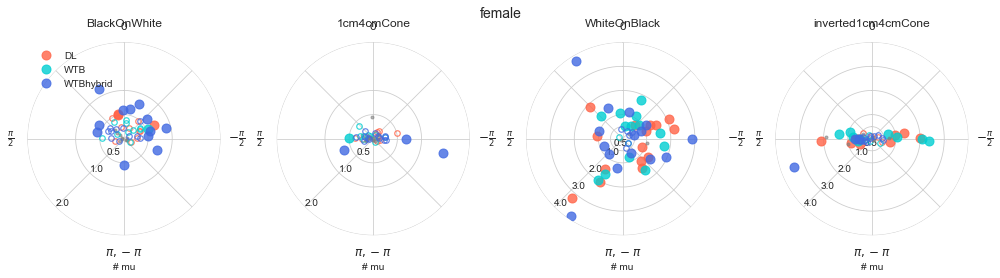

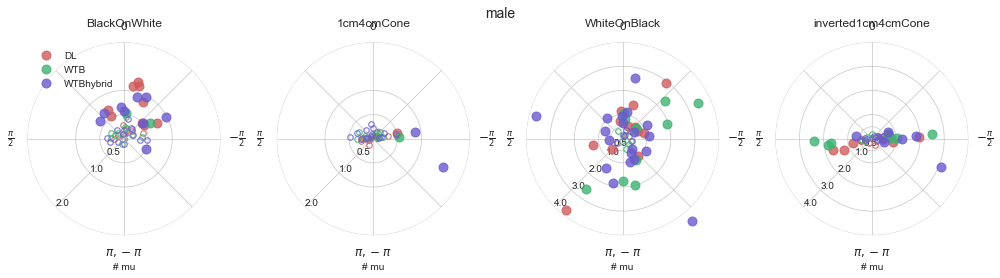

In [411]:
sceneYLim = [2,2,4,4]
ytickvals = [0.5, 1, 2, 3, 4]
for si, sex in enumerate(sexs):
    fixFig = plt.figure(figsize=(14,4))
    fixFig.suptitle(sex,fontsize=14)

    for scene, sceneName in enumerate(sceneNames):
        for groupid, group in enumerate(genotypes_df.genotype.cat.categories.tolist()):
            #polar plot of fitted location and shape parameter - unimodal
            ax = fixFig.add_subplot(1,4,scene+1, projection='polar')
            currdf = genotypes_df.query('sceneName=="{}" & sex=="{}" & genotype=="{}"'.format(sceneName,sex,group))
            notgof_df = currdf.query('gof == 0 & kappa >=0')
            if not notgof_df.empty:
                notgof_df.plot(ax=ax, x="# mu", y="kappa",color='grey', marker='.',
                              alpha=0.6, linestyle='none', grid=True, label='')
            
            gof_df = currdf.query('gof == 1 & kappa < '+str(kappaTH))
            if not gof_df.empty:
                gof_df.plot(ax=ax, x="# mu", y="kappa", 
                            color=groupCol[si][groupid], marker='.',
                           alpha=0.8, markerfacecolor='none',  markeredgewidth=1.2, markersize = 11,
                            linestyle='none',grid=True, label='')
            
            fix_df = currdf.query('gof == 1 & kappa >= '+str(kappaTH))
            if not fix_df.empty:
                if scene== 0:
                    fix_df.plot(ax=ax, x="# mu", y="kappa", color=groupCol[si][groupid], marker='o',
                                markersize = 9, alpha=0.8, linestyle='none', grid=True, label=group)
                else:
                    fix_df.plot(ax=ax, x="# mu", y="kappa", color=groupCol[si][groupid], marker='o',
                                markersize = 9, alpha=0.8, linestyle='none', grid=True, label='')
                               
            stylePolarPlot(sceneName,ax,sceneYLim,ytickvals,scene)
            
            ax.legend(loc=2)
        
    fixFig.tight_layout()
    fixFig.savefig(analysisDir+ '/allGenotypes_vMFixation_highT-cut_' + sex+ '_uniModalFixation.pdf', format='pdf') 

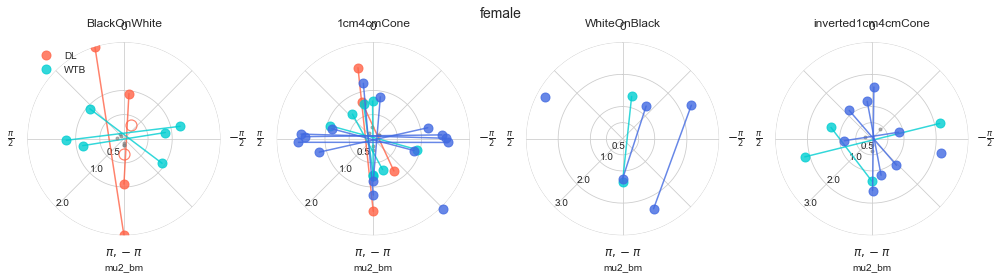

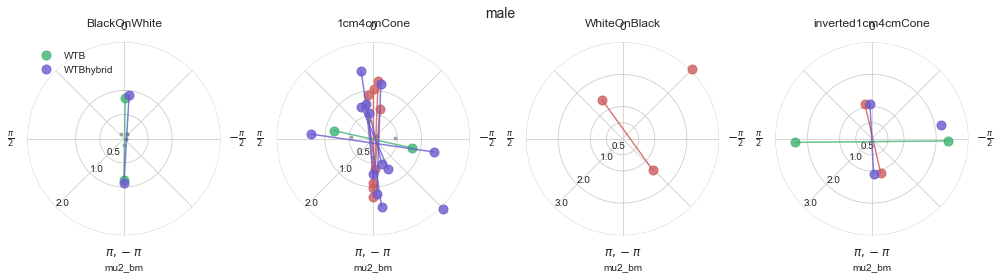

In [412]:
sceneYLim = [2,2,3,3]
ytickvals = [0.5, 1, 2, 3, 4]

for si, sex in enumerate(sexs):
    fixFig = plt.figure(figsize=(14,4))
    fixFig.suptitle(sex,fontsize=14)

    for sc, sceneName in enumerate(sceneNames):
        
        for groupid, group in enumerate(genotypes_df.genotype.cat.categories.tolist()):
            #polar plot of fitted location and shape parameter - unimodal
            ax = fixFig.add_subplot(1,4,sc+1, projection='polar')
            currdf = genotypes_df.query('sceneName=="{}" & sex=="{}" & genotype=="{}"'.format(sceneName,sex,group))
            notgof_df = currdf.query('gof_bm == 0 & kappa_bm >=0')
            
            if not notgof_df.empty:
                notgof_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", color='grey', marker='.',
                                alpha=0.6, linestyle='none', grid=True, label='')
                notgof_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color='grey', marker='.',
                                alpha=0.6, linestyle='none', grid=True, label='')
            
            gof_df = currdf.query('gof_bm == 1 & kappa_bm < '+str(kappaTH))
            if not gof_df.empty:
                gof_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", markeredgecolor=groupCol[si][groupid], marker='o',
                            alpha=0.8, markerfacecolor='none',  markeredgewidth=1.2, markersize = 11,
                            linestyle='none',grid=True, label='')
                gof_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", markeredgecolor=groupCol[si][groupid], marker='o',
                            alpha=0.8, markerfacecolor='none',  markeredgewidth=1.2, markersize = 11,
                            linestyle='none',grid=True, label='')
            
            fix_df = currdf.query('gof_bm == 1 & kappa_bm >= '+str(kappaTH))
            if not fix_df.empty:
                try:
                    x = [fix_df["mu1_bm"].values, fix_df["mu2_bm"].values]
                    y = [fix_df["kappa_bm"].values, fix_df["kappa_bm"].values]
                    ax.plot(x,y,alpha=0.8, color=groupCol[si][groupid], linewidth=1.5,label='')
                except KeyError:
                    print("KeyError " + group)
                    print(x)
                    
                fix_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", color=groupCol[si][groupid], marker='o',
                            markersize = 9, alpha=0.8, linestyle='none', grid=True,label='')
                if sc == 0:
                    fix_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color=groupCol[si][groupid], marker='o',
                                markersize = 9, alpha=0.8, linestyle='none', grid=True,label=group)
                else:
                    fix_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color=groupCol[si][groupid], marker='o',
                                markersize = 9, alpha=0.8, linestyle='none', grid=True,label='')

        stylePolarPlot(sceneName,ax,sceneYLim,ytickvals,sc)
        ax.legend(loc=2)
        
    fixFig.tight_layout()
    fixFig.savefig(analysisDir+ '/allGenotypes_vMFixation_highT-cut_' + sex + '_biModalFixation.pdf', format='pdf') 

### Visualisation with ggplot and R magic

In [175]:
fitdata_df

genotype       group wings room temp     sex scene      contrast  \
0        WTB  high-T-cut   cut      high    male    1D  darkOnBright   
1        WTB  high-T-cut   cut      high    male    1D  darkOnBright   
2        WTB  high-T-cut   cut      high    male    1D  darkOnBright   
3        WTB  high-T-cut   cut      high    male    1D  darkOnBright   
4        WTB  high-T-cut   cut      high    male    1D  darkOnBright   
5        WTB  high-T-cut   cut      high    male    1D  darkOnBright   
6        WTB  high-T-cut   cut      high    male    1D  darkOnBright   
7        WTB  high-T-cut   cut      high    male    1D  darkOnBright   
8        WTB  high-T-cut   cut      high    male    1D  darkOnBright   
9        WTB  high-T-cut   cut      high    male    1D  darkOnBright   
10       WTB  high-T-cut   cut      high    male    1D  darkOnBright   
11       WTB  high-T-cut   cut      high    male    1D  darkOnBright   
12       WTB  high-T-cut   cut      high    male    1D  darkOnBright   
13       WTB  high-T-cut   cut      high    male    1D  darkOnBright   
14       WTB  high-T-cut   cut      high    male    1D  darkOnBright   
15       WTB  high-T-cut   cut      high    male    1D  darkOnBright   
16       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
17       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
18       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
19       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
20       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
21       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
22       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
23       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
24       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
25       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
26       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
27       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
28       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
29       WTB  high-T-cut   cut      high    male    2D  darkOnBright   
..       ...         ...   ...       ...     ...   ...           ...   
418       DL  high-T-cut   cut      high  female    1D  brightOnDark   
419       DL  high-T-cut   cut      high  female    1D  brightOnDark   
420       DL  high-T-cut   cut      high  female    1D  brightOnDark   
421       DL  high-T-cut   cut      high  female    1D  brightOnDark   
422       DL  high-T-cut   cut      high  female    1D  brightOnDark   
423       DL  high-T-cut   cut      high  female    1D  brightOnDark   
424       DL  high-T-cut   cut      high  female    1D  brightOnDark   
425       DL  high-T-cut   cut      high  female    1D  brightOnDark   
426       DL  high-T-cut   cut      high  female    1D  brightOnDark   
427       DL  high-T-cut   cut      high  female    1D  brightOnDark   
428       DL  high-T-cut   cut      high  female    1D  brightOnDark   
429       DL  high-T-cut   cut      high  female    1D  brightOnDark   
430       DL  high-T-cut   cut      high  female    1D  brightOnDark   
431       DL  high-T-cut   cut      high  female    1D  brightOnDark   
432       DL  high-T-cut   cut      high  female    1D  brightOnDark   
433       DL  high-T-cut   cut      high  female    2D  brightOnDark   
434       DL  high-T-cut   cut      high  female    2D  brightOnDark   
435       DL  high-T-cut   cut      high  female    2D  brightOnDark   
436       DL  high-T-cut   cut      high  female    2D  brightOnDark   
437       DL  high-T-cut   cut      high  female    2D  brightOnDark   
438       DL  high-T-cut   cut      high  female    2D  brightOnDark   
439       DL  high-T-cut   cut      high  female    2D  brightOnDark   
440       DL  high-T-cut   cut      high  female    2D  brightOnDark   
441       DL  high-T-cut   cut      high  fe

In [176]:
# enable R Kernel 
%load_ext rpy2.ipython

ImportError: No module named rpy2.ipython

In [177]:
%%R -i fitdata_df -w 700 -h 300 -u px

library(ggplot2)

x <- ggplot(fitdata_df, aes(x=kappa, y=kappa_bm, color=as.factor(trialType))) + 
     geom_point(aes(shape=group)) + geom_smooth(method=lm,se=FALSE,fullrange=FALSE) +
     facet_grid(. ~ contrast) +
     xlim(0, 0.8) + ylim(0, 4) + theme_bw()
print(x)

for (trial in c(1,2,3,4)){
    scene1dat_df <- subset(fitdata_df, trialType==trial)

    lmfit <- lm(kappa_bm ~ kappa, data = scene1dat_df)
    summary(lmfit)
}

ERROR:root:Cell magic `%%R` not found.


In [178]:
%%R -i fitdata_df -w 700 -h 300 -u px

trial <- 4
scene1dat_df <- subset(fitdata_df, trialType==trial)

lmfit <- lm(kappa_bm ~ kappa, data = scene1dat_df)
s <- capture.output(summary(lmfit))

ERROR:root:Cell magic `%%R` not found.


In [179]:
#trial 4
a =%R s
for line in a:
    print(line)

ERROR:root:Line magic function `%R` not found.


TypeError: 'NoneType' object is not iterable

In [180]:
#trial 3
a =%R s
for line in a:
    print(line)

ERROR:root:Line magic function `%R` not found.


TypeError: 'NoneType' object is not iterable

In [181]:
#trial 2
a =%R s
for line in a:
    print(line)

ERROR:root:Line magic function `%R` not found.


TypeError: 'NoneType' object is not iterable

In [182]:
#trial 1
a =%R s
for line in a:
    print(line)

ERROR:root:Line magic function `%R` not found.


TypeError: 'NoneType' object is not iterable

In [183]:
%%R -i fitdata_df -w 800 -h 480 -u px

library(ggplot2)

x <- ggplot(fitdata_df, aes(x=mu, y=kappa, color=group, shape=as.factor(gof))) + geom_point() + coord_polar() + facet_grid(sex ~ sceneName)
x <- x + ylim(0, 3) + theme_bw()
print(x)

ERROR:root:Cell magic `%%R` not found.


In [184]:
%%R -i fitdata_df -w 800 -h 400 -u px

y <- ggplot(fitdata_df, aes(x=mu, y=mu1_bm, color=group)) + geom_point() + facet_grid(sex ~ sceneName)
y <- y + theme_bw()
print(y)

ERROR:root:Cell magic `%%R` not found.
